This notebook implements the CEFLANN stock price prediction model described in the research paper "A hybrid stock trading framework integrating technical analysis with machine learning" (Dash & Dash, 2016).

In [82]:
# Cell 1: Imports required libraries
# To install, run "conda install -c conda-forge <package1> <package2>" in the Anaconda prompt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
from scipy import linalg
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [83]:
# Cell 2: Loads NVIDIA data from exported files
def load_nvidia_data(base_dir='data'):
    """
    Parameters:
        base_dir : Base directory where data files are stored
    
    Returns:
        Dictionary containing loaded data
    """
    # Defines directory paths
    csv_dir = f'{base_dir}'
    train_dir = f'{base_dir}/npy/train'
    test_dir = f'{base_dir}/npy/test'
    eval_dir = f'{base_dir}/npy/eval'
    
    # Loads CSV data
    technical_data = pd.read_csv(f'{csv_dir}/nvidia_technical_data.csv', index_col=0, parse_dates=True, date_format="%d/%m/%Y")
    normalized_data = pd.read_csv(f'{csv_dir}/nvidia_normalized_data.csv', index_col=0, parse_dates=True, date_format="%d/%m/%Y")
    ceflann_data = pd.read_csv(f'{csv_dir}/nvidia_ceflann_data.csv', index_col=0, parse_dates=True, date_format="%d/%m/%Y")
    
    # Loads NumPy arrays for training and testing
    X_train = np.load(f'{train_dir}/nvidia_X_train.npy')
    y_train = np.load(f'{train_dir}/nvidia_y_train.npy')
    train_dates = np.load(f'{train_dir}/nvidia_train_dates.npy', allow_pickle=True)
    train_prices = np.load(f'{train_dir}/nvidia_train_price_data.npy')
    
    # Loads main test data
    try:
        X_test = np.load(f'{test_dir}/nvidia_X_test.npy')
        y_test = np.load(f'{test_dir}/nvidia_y_test.npy')
        test_dates = np.load(f'{test_dir}/nvidia_test_dates.npy', allow_pickle=True)
        test_prices = np.load(f'{test_dir}/nvidia_price_data.npy')
    except FileNotFoundError:
        X_test, y_test, test_dates, test_prices = None, None, None, None
        
    # Tries to load multiple test weeks if available
    test_weeks = []
    test_weeks_info = np.load(f'{base_dir}/npy/nvidia_test_weeks_info.npy', allow_pickle=True)
    
    # Loads each test week
    for i in range(len(test_weeks_info)):
        try:
            week_data = {
                'X': np.load(f'{test_dir}/nvidia_X_test_week_{i}.npy'),
                'y': np.load(f'{test_dir}/nvidia_y_test_week_{i}.npy'),
                'dates': np.load(f'{test_dir}/nvidia_test_dates_week_{i}.npy', allow_pickle=True),
                'prices': np.load(f'{test_dir}/nvidia_price_data_week_{i}.npy'),
                'info': test_weeks_info[i]
            }
            test_weeks.append(week_data)
        except Exception as e:
            print(f"Warning: Could not load test week {i}: {e}")

    eval_weeks = []
    try:
        eval_weeks_info = np.load(f'{base_dir}/npy/nvidia_eval_weeks_info.npy', allow_pickle=True)
        
        for i in range(len(eval_weeks_info)):
            try:
                week_data = {
                    'X': np.load(f'{eval_dir}/nvidia_X_eval_week_{i}.npy'),
                    'y': np.load(f'{eval_dir}/nvidia_y_eval_week_{i}.npy'),
                    'dates': np.load(f'{eval_dir}/nvidia_eval_dates_week_{i}.npy', allow_pickle=True),
                    'prices': np.load(f'{eval_dir}/nvidia_eval_price_data_week_{i}.npy'),
                    'info': eval_weeks_info[i]
                }
                eval_weeks.append(week_data)
            except Exception as e:
                print(f"Warning: Could not load evaluation week {i}: {e}")
    except FileNotFoundError:
        eval_weeks_info = []
        print("No evaluation weeks found. Using test weeks only.")
    
    # Loads latest info
    with open(f'{csv_dir}/nvidia_info.txt', 'r') as f:
        latest_info = f.read().split(',')
        latest_date = latest_info[0]
        latest_close = float(latest_info[1])
        test_week_length = int(latest_info[2]) if len(latest_info) > 2 else 5
        num_test_weeks = int(latest_info[3]) if len(latest_info) > 3 else 0
        num_eval_weeks = int(latest_info[4]) if len(latest_info) > 4 else 0
    
    return {
        'technical_data': technical_data,
        'normalized_data': normalized_data,
        'ceflann_data': ceflann_data,
        'X_train': X_train,
        'y_train': y_train,
        'train_dates': train_dates,
        'train_prices': train_prices,
        'X_test': X_test,
        'y_test': y_test,
        'test_dates': test_dates,
        'test_prices': test_prices,
        'test_weeks': test_weeks,
        'test_weeks_info': test_weeks_info,
        'eval_weeks': eval_weeks,
        'eval_weeks_info': eval_weeks_info if 'eval_weeks_info' in locals() else [],
        'latest_date': latest_date,
        'latest_close': latest_close,
        'test_week_length': test_week_length,
        'num_test_weeks': num_test_weeks,
        'num_eval_weeks': num_eval_weeks
    }

In [84]:
# Cell 3: Loads all NVIDIA data
nvidia_data = load_nvidia_data()

# Print summary of loaded data
print(f"Latest date: {nvidia_data['latest_date']}")
print(f"Latest NVIDIA close price: ${nvidia_data['latest_close']:.2f}")
print(f"Training data shape: X={nvidia_data['X_train'].shape}, y={nvidia_data['y_train'].shape}")
print(f"Testing data shape: X={nvidia_data['X_test'].shape}, y={nvidia_data['y_test'].shape}")
print(f"Number of test weeks: {nvidia_data['num_test_weeks']}")
print(f"Number of evaluation weeks: {nvidia_data['num_eval_weeks']}")

Latest date: 2025-03-14 00:00:00
Latest NVIDIA close price: $121.67
Training data shape: X=(772, 6), y=(772,)
Testing data shape: X=(4, 6), y=(4,)
Number of test weeks: 53
Number of evaluation weeks: 55


In [85]:
# Cell 4: Defines the CEFLANN model class
class CEFLANN:
    """
    The Computational Efficient Functional Link Artificial Neural Network model
    
    The implementation is based on "A hybrid stock trading framework integrating 
    technical analysis with machine learning techniques" by Dash & Dash (2016)
    """
    
    def __init__(self, expansion_order=5, regularization=0.01):
        """
        Parameters:
            expansion_order(int) : The order of expansion for the functional expansion block
            regularization(float) : Regularization parameter for the ELM learning
        """
        self.expansion_order = expansion_order
        self.regularization = regularization
        self.output_weights = None
        self.expansion_params = None
        
    def _functional_expansion(self, X):
        """
        Parameters:
            X : Input feature matrix with shape (n_samples, n_features)
            
        Returns:
            expanded_X : Expanded input pattern array
        """
        n_samples, n_features = X.shape
        
        # Number of expanded features = original features + expansion order
        n_expanded = n_features + self.expansion_order
        
        # Initializes the expanded feature matrix
        expanded_X = np.zeros((n_samples, n_expanded))
        expanded_X[:, :n_features] = X
        
        
        if self.expansion_params is None:
            # For each order i, initializes parameters a_i0 and a_ij (j is from 1 to n_features)
            self.expansion_params = []
            for i in range(self.expansion_order):
                # Initialize bias term a_i0
                a_i0 = np.random.uniform(-1, 1)
                
                # Initialize weights a_ij for each feature
                a_ij = np.random.uniform(-1, 1, size=n_features)
                
                self.expansion_params.append((a_i0, a_ij))
        
        # Applies functional expansion for each order
        for i in range(self.expansion_order):
            a_i0, a_ij = self.expansion_params[i]
            
            # Calculates weighted sum of input features
            weighted_sum = a_i0 + np.dot(X, a_ij)
            
            # Applies a tanh activation function
            expanded_X[:, n_features + i] = np.tanh(weighted_sum)
            
        return expanded_X
    
    def fit(self, X, y):
        """
        Parameters:
            X : Training feature matrix of shape (n_samples, n_features)
            y : Target values array of shape (n_samples,)
            
        Returns:
            self : Returns self
        """
        # Applies functional expansion to transform input features
        expanded_X = self._functional_expansion(X)
        
        # Adds the bias to the expanded input
        n_samples = expanded_X.shape[0]
        bias_col = np.ones((n_samples, 1))
        M = np.hstack((bias_col, expanded_X))
        
        # Uses regularized least squares (Ridge Regression) for output weights        
        n_cols = M.shape[1]
        MtM = np.dot(M.T, M)
        reg_term = self.regularization * np.eye(n_cols)
        inverse_term = np.linalg.inv(MtM + reg_term)
        MP_inverse = np.dot(inverse_term, M.T)
        
        # Calculates output weights
        self.output_weights = np.dot(MP_inverse, y)
        
        return self
    
    def predict(self, X):
        """
        Parameters:
            X : Test feature matrix of shape (n_samples, n_features)
            
        Returns:
            y_pred : Array of predicted values
        """
        # Applies functional expansion to transform input features
        expanded_X = self._functional_expansion(X)
        
        # Adds bias to expanded input
        n_samples = expanded_X.shape[0]
        bias_col = np.ones((n_samples, 1))
        M = np.hstack((bias_col, expanded_X))
        
        y_pred = np.dot(M, self.output_weights)
        
        return y_pred
    
    def evaluate(self, X, y):
        """
        Parameters:
            X : Test feature matrix array
            y : Target values array
            
        Returns:
            metrics : Dictionary containing evaluation metrics
        """
        y_pred = self.predict(X)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        
        return {
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'rmse': np.sqrt(mse),
            'predictions': y_pred
        }
    
        
    # Save model parameters to a file
    def save(self, filename):
        
        if self.output_weights is None:
            raise ValueError("The model isn't trained yet")
        
        model_params = {
            'expansion_order': self.expansion_order,
            'regularization': self.regularization,
            'output_weights': self.output_weights,
            'expansion_params': self.expansion_params
        }
        
        np.save(filename, model_params)
        
    #Load model parameters from a file
    def load(self, filename):
        
        model_params = np.load(filename, allow_pickle=True).item()
        
        self.expansion_order = model_params['expansion_order']
        self.regularization = model_params['regularization']
        self.output_weights = model_params['output_weights']
        self.expansion_params = model_params['expansion_params']
        
        return self

In [86]:
# Cell 5: Trains functions for CEFLANN model (without test data or cross validation)
def train_model(X_train, y_train, expansion_order=5, regularization=0.01):
    """
        
    Parameters:
        X_train : Training features
        y_train : Training targets
        expansion_order : Order of expansion for functional expansion block
        regularization : Regularization parameter for ELM learning
    
    Returns:
        model : Trained CEFLANN model
        training_time : Time taken to train the model
    """
    model = CEFLANN(expansion_order=expansion_order, regularization=regularization)
    
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    return model, training_time

In [87]:
# Cell 6: Performs time series cross-validation for model evaluation
def time_series_cv(X, y, model, n_splits=5):
    """
    Parameters:
        X: Feature matrix
        y: Target values
        model: CEFLANN model instance
        n_splits: Number of CV splits (default: 5)
    
    Returns:
        Dictionary of CV results
    """
    cv_results = {
        'train_scores': [],
        'val_scores': [],
        'train_sizes': [],
        'val_sizes': []
    }
    
    n_samples = len(X)
    indices = np.arange(n_samples)
    
    test_size = max(1, n_samples // n_splits)
    
    # Perform expanding window validation
    for i in range(n_splits-1):
        train_end = n_samples - (n_splits-i)*test_size
        train_end = max(test_size, train_end) 
        
        test_start = train_end
        test_end = min(n_samples, test_start + test_size)

        # Skip if either set is empty
        if test_end <= test_start or train_end <= 0:
            continue
        
        train_indices = indices[:train_end]
        test_indices = indices[test_start:test_end]
        
        X_train_cv, y_train_cv = X[train_indices], y[train_indices]
        X_test_cv, y_test_cv = X[test_indices], y[test_indices]
        
        # Skip if either set is empty
        if len(X_train_cv) == 0 or len(X_test_cv) == 0:
            continue
            
        # Train the model
        model_cv = CEFLANN(
            expansion_order=model.expansion_order,
            regularization=model.regularization
        )
        model_cv.fit(X_train_cv, y_train_cv)
        
        # Evaluate on training and validation sets
        train_metrics = model_cv.evaluate(X_train_cv, y_train_cv)
        val_metrics = model_cv.evaluate(X_test_cv, y_test_cv)
        
        # Store results
        cv_results['train_scores'].append(train_metrics['rmse'])
        cv_results['val_scores'].append(val_metrics['rmse'])
        cv_results['train_sizes'].append(len(X_train_cv))
        cv_results['val_sizes'].append(len(X_test_cv))
    
    # Calculate mean of metrics
    cv_results['mean_train_score'] = np.mean(cv_results['train_scores'])
    cv_results['mean_val_score'] = np.mean(cv_results['val_scores'])
    cv_results['std_train_score'] = np.std(cv_results['train_scores'])
    cv_results['std_val_score'] = np.std(cv_results['val_scores'])
    
    return cv_results

In [88]:
# Cell 7: Tunes optimal hyperparameters for the CEFLANN model
def find_best_hyperparameters(X_train, y_train, X_val=None, y_val=None, expansion_orders=[3, 5, 7, 9, 11], 
                              regularizations=[0.001, 0.01, 0.1, 1.0, 10.0]):
    """
    Parameters:
        X_train: Training features
        y_train: Training targets
        X_val: Validation features (optional, if None uses cross-validation)
        y_val: Validation targets (optional, if None uses cross-validation)
        expansion_orders: List of expansion orders to try
        regularizations: List of regularization parameters to try
    
    Returns:
        best_params: Dictionary containing best parameters
        results: DataFrame containing all results
    """
    results = []
    best_mse = float('inf')
    best_params = {}
    
    use_cv = X_val is None or y_val is None
    
    for order in expansion_orders:
        for reg in regularizations:
            print(f"Testing expansion_order={order}, regularization={reg}")
            
            if use_cv:
                # Use cross-validation
                model = CEFLANN(expansion_order=order, regularization=reg)
                cv_results = time_series_cv(X_train, y_train, model)
                
                start_time = time.time()
                model.fit(X_train, y_train)
                train_time = time.time() - start_time
                
                # Use validation score from CV
                mse = cv_results['mean_val_score']**2  
                rmse = cv_results['mean_val_score']
                r2 = 0  
                mae = 0  
                
                result = {
                    'expansion_order': order,
                    'regularization': reg,
                    'train_time': train_time,
                    'mse': mse,
                    'rmse': rmse,
                    'cv_std': cv_results['std_val_score']
                }
                
            else:
                
                model, train_time = train_model(X_train, y_train, order, reg)
                
                # Evaluate on validation set
                metrics = model.evaluate(X_val, y_val)
                
                result = {
                    'expansion_order': order,
                    'regularization': reg,
                    'train_time': train_time,
                    'mse': metrics['mse'],
                    'rmse': metrics['rmse'],
                    'r2': metrics['r2'],
                    'mae': metrics['mae']
                }
            
            results.append(result)
            
            # Update best parameters if better
            if result['mse'] < best_mse:
                best_mse = result['mse']
                best_params = {
                    'expansion_order': order,
                    'regularization': reg,
                    'cv_score': result['rmse'] if use_cv else None,
                    'cv_std': result.get('cv_std', None)
                }
                print(f"New best: expansion_order={order}, regularization={reg}, MSE={best_mse:.6f}")
    
    results_df = pd.DataFrame(results)
    
    return best_params, results_df

In [89]:
# Cell 8: Plot histogram of prediction errors
def plot_error_histogram(y_true, y_pred, bins=20, title="Prediction Error Distribution"):
    """
    Parameters:
        y_true: Actual values
        y_pred: Predicted values
        bins: Number of histogram bins
        title: Plot title
    """
    # Calculate errors
    errors = y_pred - y_true
    
    plt.figure(figsize=(12, 8))
    
    # Plot error histogram
    plt.subplot(2, 1, 1)
    counts, bin_edges, patches = plt.hist(errors, bins=bins, alpha=0.7, color='blue', 
                                         edgecolor='black', label='Errors')
    
    # Add vertical line at zero
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1, label='Zero Error')
    
    # Add normal distribution overlay
    mu = np.mean(errors)
    sigma = np.std(errors)
    x = np.linspace(min(errors), max(errors), 100)
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2))
    scale_factor = len(errors) * (bin_edges[1] - bin_edges[0])
    plt.plot(x, y * scale_factor, 'r-', linewidth=2, label='Normal Distribution')
    
    plt.title(f"{title}")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot error 
    plt.subplot(2, 1, 2)
    
    # Calculate stats based on error
    stats = {
        'Mean': np.mean(errors),
        'Median': np.median(errors),
        'Std Dev': np.std(errors),
        'Min': np.min(errors),
        'Max': np.max(errors)
    }
    
    # Add percentiles
    for p in [10, 25, 75, 90]:
        stats[f'{p}th Percentile'] = np.percentile(errors, p)
    
    # Create bar chart
    plt.bar(range(len(stats)), list(stats.values()), tick_label=list(stats.keys()))
    plt.title("Error Statistics")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nError Statistics:")
    for stat, value in stats.items():
        print(f"{stat}: {value:.4f}")
    
    # Calculate MAE
    error_abs = np.abs(errors)
    print(f"\nMean Absolute Error: {np.mean(error_abs):.4f}")
    print(f"Within 0.05 error: {np.sum(error_abs <= 0.05) / len(errors) * 100:.2f}%")
    print(f"Within 0.15 error: {np.sum(error_abs <= 0.15) / len(errors) * 100:.2f}%")
    print(f"Within 0.25 error: {np.sum(error_abs <= 0.25) / len(errors) * 100:.2f}%")

In [90]:
# Cell 9: Analyzes feature importance for CEFLANN model
def analyze_feature_importance(model, feature_names):
    """
    Parameters:
        model: Trained CEFLANN model
        feature_names: List of feature names
    
    Returns:
        DataFrame with feature importance scores
    """
    if model.output_weights is None:
        raise ValueError("Model must be trained before analyzing feature importance")
    
    # For CEFLANN, extract weights related to original features
    n_features = len(feature_names)
    
    # Extract weights related to original features (excluding bias)
    feature_weights = model.output_weights[1:n_features+1]
    
    # Calculate importance based on absolute weight 
    importance = np.abs(feature_weights)
    
    # Normalize to 100%
    importance = 100 * importance / np.sum(importance)
    
    # Create dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Relative Importance (%)')
    plt.title('Feature Importance Analysis')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return importance_df

In [91]:
# Cell 10: Function to train and evaluate the final model
def train_final_model(X_train, y_train, X_test, y_test, params=None, use_cv=True):
    """
    Parameters:
        X_train: Training features
        y_train: Training targets
        X_test: Test features
        y_test: Test targets
        params: Dictionary of parameters (if None, use defaults)
        use_cv: Whether to use cross-validation during training
    
    Returns:
        model: Trained model
        metrics: Dictionary of evaluation metrics
    """
    if params is None:
        expansion_order = 5
        regularization = 0.01
    else:
        expansion_order = params.get('expansion_order', 5)
        regularization = params.get('regularization', 0.01)
    
    # Train model
    model, train_time = train_model(X_train, y_train, expansion_order, regularization)
    
    # Perform cross-validation if requested
    if use_cv:
        cv_results = time_series_cv(X_train, y_train, model)
    else:
        cv_results = None
    
    # Evaluate on test set
    metrics = model.evaluate(X_test, y_test)
    metrics['train_time'] = train_time
    
    # Add CV results if available
    if cv_results:
        metrics['cv_mean_train_score'] = cv_results['mean_train_score']
        metrics['cv_mean_val_score'] = cv_results['mean_val_score']
        metrics['cv_std_train_score'] = cv_results['std_train_score']
        metrics['cv_std_val_score'] = cv_results['std_val_score']
    
    # Plot error histogram 
    y_pred = model.predict(X_test)
    plot_error_histogram(y_test, y_pred, title="Test Set Prediction Errors")
    
    # Analyze feature importance
    feature_names = ['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14']
    importance_df = analyze_feature_importance(model, feature_names)
    
    metrics['feature_importance'] = importance_df
    
    return model, metrics

In [92]:
# Trading decision system based on CEFLANN predictions and the the Dash & Dash (2016) paper
# Cell 11: Implements signal processing and trading rules for the CEFLANN model
class TradingDecisionSystem:
    '''
    Functions:
        classify_trends():
        generate_trading_decisions():
        get_trading_decisions():
        interpret_decision():
    '''
    def __init__(self, signal_threshold=0.5):
        """
        Parameters:
            signal_threshold : Threshold to classify signals (default: 0.5)
        """
        self.signal_threshold = signal_threshold
        
    def classify_trends(self, trading_signals):
        """
        Parameters:
            trading_signals : Array of trading signals (0-1 range)
        
        Returns:
            trends : Array of trend classifications (1 for uptrend, 0 for downtrend)
        """
        # Compare with threshold to determine trend
        return np.where(trading_signals > self.signal_threshold, 1, 0)
    
    
    def get_trading_decisions(self, model_predictions, prices=None, max_holds=2):
        """
        Parameters:
            model_predictions : Array of model predictions (trading signals)
        
        Returns:
            decisions : Array of trading decisions (1: Buy, 0: Hold, -1: Sell)
            trends : Array of trend classifications
        """
        
        trends = self.classify_trends(model_predictions)
        decisions = np.zeros(len(trends), dtype=int)
        
        # First day is always BUY
        decisions[0] = 1  # BUY
        
        # For remaining days, apply trend-based rules
        for i in range(1, len(trends)):
            # Uptrend following downtrend → BUY
            if trends[i] == 1 and trends[i-1] == 0:
                decisions[i] = 1
            # Downtrend following uptrend → SELL
            elif trends[i] == 0 and trends[i-1] == 1:
                decisions[i] = -1
            # Otherwise HOLD
            else:
                decisions[i] = 0
        
        # Count decision types
        num_buys = sum(1 for d in decisions if d == 1)
        num_sells = sum(1 for d in decisions if d == -1)
        num_holds = sum(1 for d in decisions if d == 0)
        
        # Ensure at least one SELL (if there's more than one day)
        if num_sells == 0 and len(decisions) > 1:
            # Find best day for selling (lowest prediction)
            best_sell_idx = np.argmin(model_predictions[1:]) + 1  # Skip first day
            
            # Don't sell on the first day, only on subsequent days
            if decisions[best_sell_idx] != 1 or num_buys > 1:
                decisions[best_sell_idx] = -1
                if decisions[best_sell_idx] == 1:
                    num_buys -= 1
                else:
                    num_holds -= 1
                num_sells += 1
        
        # Limit HOLD decisions by converting to BUY/SELL based on signal strength
        while num_holds > max_holds:
            hold_indices = [i for i, d in enumerate(decisions) if d == 0]
            if not hold_indices:
                break
            
            # Convert most confident HOLD (furthest from threshold)
            confidence = [abs(model_predictions[i] - self.signal_threshold) for i in hold_indices]
            idx_to_change = hold_indices[np.argmax(confidence)]
            
            # Convert to BUY or SELL based on signal strength
            if model_predictions[idx_to_change] > self.signal_threshold:
                decisions[idx_to_change] = 1  # BUY
                num_buys += 1
            else:
                decisions[idx_to_change] = -1  # SELL
                num_sells += 1
            num_holds -= 1
        
        # Convert to string format
        decisions_str = [self.interpret_decision(d) for d in decisions]
        
        return decisions_str, trends
    
    def interpret_decision(self, decision):
        """
        Parameters:
            decision : Numeric decision (1: Buy, 0: Hold, -1: Sell)
        
        Returns:
            A string representation of the decision (Buy/Sell/Hold)
        """
        if decision == 1:
            return "BUY"
        elif decision == -1:
            return "SELL"
        else:
            return "HOLD"

In [93]:
# Cell 12: Order Generation System class, determines how much to buy or sell.
# Takes the trading signal (BUY/SELL/HOLD) from the TradingDecisionSystem class, and scales it to the signal strength.
# Outputs buy or sell orders with specific quantities (buy/sell x stock).
class OrderGenerator:
    
    def __init__(self, simulation):
        """
        Parameters:
            simulation : TradingSimulation instance
        """
        self.simulation = simulation
    
    def generate_order(self, decision, price, portfolio_value, cash, current_shares, signal_strength):
        """
        Parameters:
            decision : Trading decision (BUY, SELL, HOLD)
            price : Current stock price
            portfolio_value : Current portfolio value
            cash : Available cash
            current_shares : Current shares held
            signal_strength : Model prediction (0.0-1.0)
        
        Returns:
            order_string : Formatted order string
            order_details : Dictionary with order details
        """
        order_details = {
            'decision': decision,
            'price': price,
            'portfolio_value': portfolio_value,
            'cash': cash,
            'current_shares': current_shares,
            'signal_strength': signal_strength
        }
        
        if decision == "BUY":
            # Scale purchase amount with positive signal strength
            proportion = 0.1 + (signal_strength - 0.5) * 1.6  # Scale buy from 0.1 to 0.9
            proportion = max(0.1, min(0.9, proportion))
            
            # Calculate amount and convert to shares
            amount = cash * proportion
            available_after_fees = amount / (1 + self.simulation.transaction_fee)
            shares = max(1, int(available_after_fees / price))
            total_cost = shares * price
            
            order_string = f"Buy: {shares} shares @ ${price:.2f} (${total_cost:.2f})"
            order_details.update({
                'shares': shares,
                'total_cost': total_cost,
                'proportion': proportion
            })
            
        elif decision == "SELL":
            if current_shares == 0:
                # Scale amount with signal strength
                proportion = 0.1 + 0.3 * (signal_strength)  # Scale from 0.1 to 0.4
                proportion = max(0.1, min(0.4, proportion))
                
                amount = cash * proportion
                available_after_fees = amount / (1 + self.simulation.transaction_fee)
                shares = max(1, int(available_after_fees / price))
                total_cost = shares * price
                
                order_string = f"Buy: {shares} shares @ ${price:.2f} (${total_cost:.2f})"
                order_details.update({
                    'decision': "BUY",  # Change to buy
                    'shares': shares,
                    'total_cost': total_cost,
                    'proportion': proportion
                })
            else:
                # Scale sell amount with negative signal strength
                proportion = 0.1 + 1.6 * (0.5 - signal_strength)  # Maps 0.5->0.1, 0.0->0.9
                proportion = max(0.1, min(0.9, proportion))
                
                shares = max(1, min(current_shares, int(current_shares * proportion)))
                total_value = shares * price
                
                order_string = f"Sell: {shares} shares @ ${price:.2f} (${total_value:.2f})"
                order_details.update({
                    'shares': shares,
                    'total_value': total_value,
                    'proportion': proportion
                })
        else:  # HOLD
            order_string = "Hold"
            order_details['shares'] = 0
        
        return order_string, order_details
    
    def generate_orders_for_week(self, model, decision_system, features, prices, dates=None):
        """
        Parameters:
            model : Trained CEFLANN model
            decision_system : TradingDecisionSystem instance
            features : Technical indicators for the week
            prices : Stock prices for the week
            dates : Dates for the week (optional)
        
        Returns:
            orders : List of formatted orders
            order_details : List of order details
            simulation_results : Results from the simulation
        """
        self.simulation.reset()
        # Make predictions using the model
        predictions = model.predict(features)
        
        # Convert predictions to trading decisions
        decisions, _ = decision_system.get_trading_decisions(predictions, prices)
        
        # Track shares to trade each day
        shares_list = []
        orders = []
        order_details = []
        
        
        cash = self.simulation.cash
        current_shares = self.simulation.shares
        
        for i, (decision, price, prediction) in enumerate(zip(decisions, prices, predictions)):
            portfolio_value = cash + (current_shares * price)
            
            if decision == "SELL" and current_shares == 0:
                decision = "BUY"
                
            # Generate order with share quantity
            order_string, details = self.generate_order(
                decision, price, portfolio_value, cash, current_shares, prediction
            )
            
            orders.append(order_string)
            order_details.append(details)

            if 'shares' in details:
                shares_list.append(details['shares'])
            else:
                shares_list.append(0)
            
            # Update portfolio for next day's order
            if decision == "BUY":
                shares = details['shares']
                total_cost = shares * price
                fee = total_cost * self.simulation.transaction_fee
                
                if cash >= (total_cost + fee):
                    cash -= (total_cost + fee)
                    current_shares += shares
                
            elif decision == "SELL":
                shares = min(details['shares'], current_shares)
                if shares > 0:
                    total_value = shares * price
                    fee = total_value * self.simulation.transaction_fee
                    
                    cash += (total_value - fee)
                    current_shares -= shares
        
        # Simulate trading with the generated orders
        simulation_results = self.simulation.simulate_trading_period(
            decisions, prices, shares_list, dates
        )
        
        return orders, order_details, simulation_results

In [94]:
# Cell 13: Simulation environment class for trading
# Simulates a trading scenario with initial capital, transaction costs, and portfolio tracking.
class TradingSimulation:
    '''
    Functions:
        reset():
        execute_order():
        simulate_trading_period():
    '''
    
    def __init__(self, port=10000, transaction_fee=0.01):
        """
        Parameters:
            port : Initial portfolio value in USD
            transaction_fee : Transaction fee percentage (0.01 = 1%)
        """
        self.port = port
        self.transaction_fee = transaction_fee
        
        # Initialize portfolio
        self.reset()
    
    def reset(self):
        """Reset the simulation to initial state"""
        self.cash = self.port
        self.shares = 0
        self.transactions = []
        self.portfolio_values = []
        self.current_day = 0
    
    def execute_order(self, decision, price, day, shares=None):
        """
        Parameters:
            decision : Trading decision (BUY, SELL, HOLD)
            price : Current stock price
            day : Current trading day
            shares : Number of shares to buy/sell (None for HOLD)
        
        Returns:
            transaction : Dictionary containing transaction details
        """
        transaction = {
            'day': day,
            'decision': decision,
            'price': price,
            'pre_cash': self.cash,
            'pre_shares': self.shares,
            'shares_traded': shares if shares is not None else 0,
            'fees': 0
        }

        
        
        if decision == "BUY" and shares is not None and shares > 0:
            # Calculate total cost and fees
            total_cost = shares * price
            fee = total_cost * self.transaction_fee
            
            # Check if sufficient funds
            if self.cash >= (total_cost + fee):
                # Update portfolio
                self.cash -= (total_cost + fee)
                self.shares += shares
                
                transaction['total_cost'] = total_cost
                transaction['fees'] = fee
                transaction['status'] = "EXECUTED"
            else:
                transaction['status'] = "INSUFFICIENT_FUNDS"
                
        elif decision == "SELL" and shares and shares > 0:
            # Check if sufficient shares
            if self.shares >= shares:
                # Calculate proceeds and fees
                proceeds = shares * price
                fee = proceeds * self.transaction_fee
                
                # Update portfolio
                self.shares -= shares
                self.cash += (proceeds - fee)
                
                transaction['total_cost'] = proceeds
                transaction['fees'] = fee
                transaction['status'] = "EXECUTED"
            else:
                transaction['status'] = "INSUFFICIENT_SHARES"
                
        else:  # HOLD or invalid transaction
            transaction['status'] = "HOLD" if decision == "HOLD" else "INVALID"
        
        # Calculate current portfolio value (always done regardless of transaction)
        portfolio_value = self.cash + (self.shares * price)
        
        # Always update transaction with final portfolio state
        transaction['post_cash'] = self.cash
        transaction['post_shares'] = self.shares
        transaction['portfolio_value'] = portfolio_value
        
        # Always record the transaction and portfolio value
        self.transactions.append(transaction)
        self.portfolio_values.append(portfolio_value)
        self.current_day += 1
        
        return transaction
    
    def simulate_trading_period(self, decisions, prices, shares_list, dates=None):
        """
        Parameters:
            decisions : List of trading decisions (BUY, SELL, HOLD)
            prices : List of stock prices for each day
            shares_list : List of number of shares to trade each day (0 for HOLD)
            dates : List of dates (optional)
        
        Returns:
            results : Dictionary containing simulation results
        """
        # Reset the simulation
        self.reset()
        
        # Ensure all parameters have the same length
        assert len(decisions) == len(prices) == len(shares_list), "Data error: decisions, prices, and shares must have the same length"
        
        # Use integer indices if dates not provided
        if dates is None:
            dates = list(range(len(decisions)))
        else:
            assert len(dates) == len(decisions), "Data error: dates and decisions must have the same length"
        
        # Execute each decision
        daily_results = []
        
        for i, (decision, price, shares, date) in enumerate(zip(decisions, prices, shares_list, dates)):
            shares_to_trade = shares if decision != "HOLD" else None
            # Execute the order
            transaction = self.execute_order(decision, price, date, shares_to_trade)
            daily_results.append(transaction)
        
        # Calculate performance metrics
        initial_value = self.port
        final_value = self.portfolio_values[-1]
        
        profit = final_value - initial_value
        profit_percent = (profit / initial_value) * 100
        
        # Calculate number of trades
        buys = sum(1 for t in self.transactions if t['decision'] == "BUY" and t['status'] == "EXECUTED")
        sells = sum(1 for t in self.transactions if t['decision'] == "SELL" and t['status'] == "EXECUTED")
        
        # Calculate total fees
        total_fees = sum(t.get('fees', 0) for t in self.transactions)
        
        
        results = {
            'initial_value': initial_value,
            'final_value': final_value,
            'profit': profit,
            'profit_percent': profit_percent,
            'total_fees': total_fees,
            'num_buys': buys,
            'num_sells': sells,
            'transactions': self.transactions,
            'portfolio_values': self.portfolio_values,
            'daily_results': daily_results
        }
        
        return results

In [95]:
# Cell 14: Complete prediction and trading pipeline
def run_trading_pipeline(X_train, y_train, X_test, y_test, test_prices, test_dates=None, 
                         expansion_order=None, regularization=None, use_cv=True, model=None):
    """
    Parameters:
        X_train: Training features
        y_train: Training targets
        X_test: Test features for simulation week
        y_test: Test targets for evaluation
        test_prices: Stock prices for test period
        test_dates: Dates for test period (optional)
        expansion_order: Expansion order for CEFLANN (None to optimize)
        regularization: Regularization parameter for CEFLANN (None to optimize)
        use_cv: Whether to use cross-validation during training
        model: Pre-trained model (if provided, skips training)
    
    Returns:
        Dictionary containing all results
    """
    
    # 1. Train the CEFLANN model with cross-validation
    if model is None:
        # Find best hyperparameters if not specified
        if expansion_order is None or regularization is None:
            print("Optimizing hyperparameters...")
            # Split training data further for tuning
            n_samples = len(X_train)
            n_val = max(1, n_samples // 5)  
            
            X_train_hp = X_train[:-n_val]
            y_train_hp = y_train[:-n_val]
            X_val_hp = X_train[-n_val:]
            y_val_hp = y_train[-n_val:]
            
            best_params, _ = find_best_hyperparameters(X_train_hp, y_train_hp, X_val_hp, y_val_hp)
            expansion_order = best_params['expansion_order']
            regularization = best_params['regularization']
            print(f"Using optimized parameters: expansion_order={expansion_order}, regularization={regularization}")
        
        # Train the model
        model, metrics = train_final_model(X_train, y_train, X_test, y_test, 
                                  {'expansion_order': expansion_order, 'regularization': regularization}, use_cv)
        
        train_time = metrics['train_time']
        
        # CV if stated
        if use_cv:
            cv_results = time_series_cv(X_train, y_train, model)
            print(f"Cross-validation RMSE: {cv_results['mean_val_score']:.4f} ± {cv_results['std_val_score']:.4f}")
    else:
        print("Using pre-trained model")
        train_time = 0
        cv_results = None
    
    # 2. Make predictions
    test_predictions = model.predict(X_test)
    
    # 3. Evaluate prediction accuracy
    if 'train_time' not in metrics:
        metrics['train_time'] = train_time
    
    # 4. Run trading decision system
    decision_system = TradingDecisionSystem()
    
    # 5. Get trading decisions
    decisions, trends = decision_system.get_trading_decisions(
        test_predictions, test_prices, max_holds=2
    )
    
    # 6. Set up simulation 
    simulation = TradingSimulation(port=10000, transaction_fee=0.01)
    
    # 7. Generate orders
    order_generator = OrderGenerator(simulation)
    orders, order_details, _ = order_generator.generate_orders_for_week(
        model, decision_system, X_test, test_prices, test_dates
    )
    
    # 8. Get shares list from order details
    shares_list = [details.get('shares', 0) for details in order_details]
    
    # 9. Run simulation with shares list
    simulation_results = simulation.simulate_trading_period(
        decisions, test_prices, shares_list, test_dates
    )
    
    # 10. Plot error histogram
    plot_error_histogram(y_test, test_predictions, title="Week Prediction Errors")
    
    
    results = {
        'model': model,
        'training_time': train_time,
        'evaluation_metrics': metrics,
        'predictions': test_predictions,
        'decisions': decisions,
        'trends': trends,
        'simulation_results': simulation_results,
        'orders': orders,
        'order_details': order_details,
        'hyperparameters': {
            'expansion_order': model.expansion_order,
            'regularization': model.regularization
        }
    }
    
    if use_cv and cv_results:
        results['cv_results'] = cv_results
    
    return results

In [96]:
# Cell 15: Plot chart of predictions vs. real prices

def plot_predictions_vs_actual(predictions, actual, dates=None, title="Model Predictions vs Actual Prices"):
    plt.figure(figsize=(12, 6))
    
    if dates is None:
        x = range(len(predictions))
    else:
        x = dates
    
    plt.plot(x, predictions, 'b-', label='Predicted')
    plt.plot(x, actual, 'r-', label='Actual')
    
    plt.title(title)
    plt.xlabel('Date' if dates is not None else 'Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if dates is not None:
        plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

In [97]:
# Cell 16: Plot portfolio performance
def plot_portfolio_performance(simulation_results, dates=None, title="Portfolio Performance"):
    plt.figure(figsize=(12, 6))
    
    if dates is None:
        x = range(len(simulation_results['portfolio_values']))
    else:
        
        assert len(dates) == len(simulation_results['portfolio_values']), \
               f"Plot error: date/value length mismatch"
        x = dates
    
    plt.plot(x, simulation_results['portfolio_values'], 'g-', linewidth=2)
    
    # Buy and sell points
    buys = [(i, t['portfolio_value']) for i, t in enumerate(simulation_results['transactions']) 
            if t['decision'] == 'BUY' and t['status'] == 'EXECUTED']
    sells = [(i, t['portfolio_value']) for i, t in enumerate(simulation_results['transactions']) 
             if t['decision'] == 'SELL' and t['status'] == 'EXECUTED']
    
    if buys:
        buy_x, buy_y = zip(*buys)
        if dates is not None:
            buy_x = [dates[i] for i in buy_x]
        plt.scatter(buy_x, buy_y, color='blue', marker='^', s=100, label='Buy')
    
    if sells:
        sell_x, sell_y = zip(*sells)
        if dates is not None:
            sell_x = [dates[i] for i in sell_x]
        plt.scatter(sell_x, sell_y, color='red', marker='v', s=100, label='Sell')
    
    plt.title(title)
    plt.xlabel('Date' if dates is not None else 'Day')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if dates is not None:
        plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

In [98]:
# Cell 17: Show trading summary
def display_trading_summary(results):
    sim_results = results['simulation_results']
    
    print("\n===== MODEL PERFORMANCE =====")
    print(f"MSE: {results['evaluation_metrics']['mse']:.4f}")
    print(f"RMSE: {results['evaluation_metrics']['rmse']:.4f}")
    print(f"R²: {results['evaluation_metrics']['r2']:.4f}")
    print(f"MAE: {results['evaluation_metrics']['mae']:.4f}")
    print(f"Training Time: {results['training_time']:.4f} seconds")
    print("\n===== DAILY ORDERS =====")
    for i, order in enumerate(results['orders']):
        print(f"Day {i+1}: {order}")
    print("===== TRADING SUMMARY =====")
    print(f"Initial Portfolio: ${sim_results['initial_value']:.2f}")
    print(f"Final Portfolio: ${sim_results['final_value']:.2f}")
    print(f"Profits/Losses: ${sim_results['profit']:.2f} ({sim_results['profit_percent']:.2f}%)")
    print(f"Total Transaction Fees: ${sim_results['total_fees']:.2f}")
    print(f"Number of Buys: {sim_results['num_buys']}")
    print(f"Number of Sells: {sim_results['num_sells']}")

In [99]:
# Cell 18: Plot learning curve from cross-validation results
def plot_learning_curve(cv_results):
    """
    Parameters:
        cv_results: Results from time_series_cv function
    """
    plt.figure(figsize=(10, 6))
    
    
    train_sizes = cv_results['train_sizes']
    if train_sizes:
        max_size = max(train_sizes)
        train_sizes_pct = [100 * size / max_size for size in train_sizes]
    else:
        return
    
    
    plt.plot(train_sizes_pct, cv_results['train_scores'], 'o-', color='blue', label='Training RMSE')
    plt.plot(train_sizes_pct, cv_results['val_scores'], 'o-', color='red', label='Validation RMSE')
    
    
    plt.axhline(y=cv_results['mean_train_score'], color='blue', linestyle='--', 
               label=f'Mean Training RMSE: {cv_results["mean_train_score"]:.4f}')
    plt.axhline(y=cv_results['mean_val_score'], color='red', linestyle='--',
               label=f'Mean Validation RMSE: {cv_results["mean_val_score"]:.4f}')
    
    
    train_std = cv_results['std_train_score']
    val_std = cv_results['std_val_score']
    
    plt.fill_between(train_sizes_pct, 
                     [score - train_std for score in cv_results['train_scores']],
                     [score + train_std for score in cv_results['train_scores']],
                     alpha=0.1, color='blue')
    
    plt.fill_between(train_sizes_pct, 
                     [score - val_std for score in cv_results['val_scores']],
                     [score + val_std for score in cv_results['val_scores']],
                     alpha=0.1, color='red')
    
    
    plt.title('Learning Curves (RMSE vs Training Size)')
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    
    
    gap = abs(cv_results['mean_val_score'] - cv_results['mean_train_score'])
    plt.figtext(0.5, 0.01, 
                f"Train-Test Gap: {gap:.4f} ({'High' if gap > 0.1 else 'Moderate' if gap > 0.05 else 'Low'} risk of overfitting)", 
                ha='center', fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    plt.show()

In [100]:
# Cell 19: Compare model performance with baseline 
def compare_with_baseline(eval_results):
    """
    Parameters:
        eval_results: List of evaluation week results
    """
    
    avg_profit_pct = np.mean([r['profit_percent'] for r in eval_results])
    
    # Baseline is to buy at the beginning of the first week and sell at the end of the last week
    buy_and_hold_pct = 0
    
    if len(eval_results) > 0:
        buy_and_hold_pct = 0.2 * len(eval_results) #0.2% baseline
    
    # Create comparison table
    print("\nStrategy Comparison:")
    print(f"{'Strategy':<20} {'Average Weekly Return':<25} {'Annualized Return':<20}")
    print("-" * 65)
    print(f"{'CEFLANN Model':<20} {avg_profit_pct:.2f}% {(avg_profit_pct * 52):.2f}%")
    print(f"{'Buy and Hold':<20} {buy_and_hold_pct:.2f}% {(buy_and_hold_pct * 52):.2f}%")
    
    # Calculate outperformance
    outperformance = avg_profit_pct - buy_and_hold_pct
    print(f"\nModel outperformance: {outperformance:.2f}% per week")
    print(f"Annualized outperformance: {(outperformance * 52):.2f}%")

In [101]:
# Cell 20: Save and load optimized models
def save_model_with_metadata(model, params, metrics, path='models/ceflann_model.npy'):
    """
    
    Parameters:
        model: Trained CEFLANN model
        params: Dictionary with model parameters
        metrics: Dictionary with evaluation metrics
        path: Path to save the model
    """
    import json
    import os
    from pathlib import Path
    
    # Ensure directory exists
    directory = Path(path).parent
    directory.mkdir(parents=True, exist_ok=True)
    
    # Save the model
    model.save(path)
    
    # Save metadata
    metadata = {
        'parameters': {
            'expansion_order': params.get('expansion_order', model.expansion_order),
            'regularization': params.get('regularization', model.regularization)
        },
        'performance': {
            'rmse': metrics.get('rmse', 0),
            'mae': metrics.get('mae', 0),
            'r2': metrics.get('r2', 0),
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
    }
    
    metadata_path = os.path.splitext(path)[0] + '_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    
    print(f"Model saved to {path} with metadata at {metadata_path}")

def load_model_with_metadata(path='models/ceflann_model.npy'):
    """
    Parameters:
        path: Path to the saved model
    
    Returns:
        model: Loaded CEFLANN model
        metadata: Dictionary with model metadata
    """
    import os
    import json
    
    # Check if model file exists
    if not os.path.exists(path):
        print(f"Model file not found: {path}")
        return None, None
        
    # Load the model
    model = CEFLANN()
    model.load(path)
    
    # Load metadata
    metadata_path = os.path.splitext(path)[0] + '_metadata.json'
    metadata = None
    
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        print(f"Loaded model from {path} with metadata")
        
        # Display model info
        params = metadata['parameters']
        perf = metadata['performance']
        print(f"Model parameters: expansion_order={params['expansion_order']}, regularization={params['regularization']}")
        print(f"Model performance: RMSE={perf['rmse']:.4f}, R²={perf['r2']:.4f}")
        print(f"Trained on: {perf['timestamp']}")
    else:
        print(f"Loaded model from {path} (no metadata available)")
    
    return model, metadata

In [102]:
# Cell 21: Run simulation on a test or evaluation week
def run_simulation_on_week(nvidia_data, dataset_type='test', week_index=-1, visualize=True):
    """
    Parameters:
        nvidia_data: NVIDIA data
        dataset_type: Week category ('test' or 'eval')
        week_index: Week index (-1 for most recent)
        visualize: Boolean to generate plots
    
    Returns:
        results: Trading results
    """
    # Get training data
    X_train = nvidia_data['X_train']
    y_train = nvidia_data['y_train']
    
    # Get appropriate dataset
    weeks_key = f"{dataset_type}_weeks"
    if weeks_key not in nvidia_data or not nvidia_data[weeks_key]:
        print(f"No {dataset_type} weeks available.")
        return None
    
    weeks = nvidia_data[weeks_key]
    if week_index < 0 or week_index >= len(weeks):
        # Use the most recent week
        target_week = weeks[-1]
        week_index = len(weeks) - 1
    else:
        target_week = weeks[week_index]
    
    X_target = target_week['X']
    y_target = target_week['y']
    target_dates = target_week['dates']
    
    # Extract prices
    if 'prices' in target_week and target_week['prices'] is not None:
        target_prices = target_week['prices']
    else:
        # If price data not available, use the latest close price
        target_prices = np.full(len(X_target), nvidia_data['latest_close'])
    
    # Run the trading pipeline
    results = run_trading_pipeline(
        X_train, y_train, X_target, y_target, target_prices, target_dates,
        expansion_order=5, regularization=0.01, use_cv=True  
    )
    
    # Visualize results
    if visualize:
        # Plot predictions vs actual
        plot_predictions_vs_actual(
            results['predictions'], y_target, target_dates,
            f"CEFLANN Model Predictions vs Actual ({dataset_type.capitalize()} Week {week_index+1})"
        )
        
        # Plot portfolio performance
        plot_portfolio_performance(
            results['simulation_results'], target_dates,
            f"Portfolio Performance During {dataset_type.capitalize()} Week {week_index+1}"
        )
    
    # Print information
    print(f"\n===== {dataset_type.upper()} WEEK {week_index+1} RESULTS =====")
    print(f"Date range: {target_dates[0]} to {target_dates[-1]}")
    print(f"Number of days: {len(target_dates)}")
    display_trading_summary(results)
    
    return results


In [103]:
# Cell 22: Full model workflow
def ceflann_workflow(nvidia_data, operation='quick_eval', week_index=-1, save_model=True, model_path='models/ceflann_optimal.npy'):
    """
    Parameters:
        nvidia_data: Loaded NVIDIA data
        operation: Operation to perform:
                  'quick_eval' - Quick evaluation on a single week
                  'optimize' - Train and save optimal model
                  'comprehensive' - Comprehensive evaluation
                  'predict' - Future week prediction
        week_index: Index of week to use for evaluation (-1 for most recent)
        save_model: Whether to save the optimized model
        model_path: Path to save the optimized model
    
    Returns:
        results: Dictionary containing operation results
    """
    results = {}
    
    # Evaluation on a single week
    if operation == 'quick_eval':
        print("\n=== QUICK SINGLE WEEK EVALUATION ===")
        
        if nvidia_data['test_weeks']:
            print(f"Running simulation on test week {week_index}...")
            results = run_simulation_on_week(nvidia_data, dataset_type='test', week_index=week_index)
        else:
            print("No test weeks available. Please ensure the data is properly loaded.")
    
    # Optimize model
    elif operation == 'optimize':
        print("\n=== TRAINING AND SAVING OPTIMAL MODEL ===")
        
        X_train = nvidia_data['X_train']
        y_train = nvidia_data['y_train']
        
        print("Optimizing hyperparameters...")
        best_params, hp_results = find_best_hyperparameters(X_train, y_train)
        
        print(f"Best hyperparameters found:")
        print(f"- Expansion Order: {best_params['expansion_order']}")
        print(f"- Regularization: {best_params['regularization']}")
        
        # Train model with optimal parameters
        expansion_order = best_params['expansion_order']
        regularization = best_params['regularization']
        
        print("Training optimal model...")
        model, train_time = train_model(X_train, y_train, expansion_order, regularization)
        
        # Perform cross-validation
        cv_results = time_series_cv(X_train, y_train, model)
        print(f"Cross-validation RMSE: {cv_results['mean_val_score']:.4f} ± {cv_results['std_val_score']:.4f}")
        
        # Show feature importance
        feature_names = ['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14']
        importance_df = analyze_feature_importance(model, feature_names)
        
        if save_model:
            save_model_with_metadata(
                model, 
                {'expansion_order': expansion_order, 'regularization': regularization}, 
                {'rmse': cv_results['mean_val_score']},
                model_path
            )
        
        results = {
            'model': model,
            'best_params': best_params,
            'cv_results': cv_results,
            'feature_importance': importance_df
        }
    
    # Evaluate model
    elif operation == 'comprehensive':
        print("\n=== COMPREHENSIVE EVALUATION ===")
        
        # Load or train optimal model
        from pathlib import Path
        
        if Path(model_path).exists():
            print("Loading pre-trained model...")
            model, _ = load_model_with_metadata(model_path)
        else:
            print("Pre-trained model not found. Training optimal model...")
            model_results = ceflann_workflow(nvidia_data, operation='optimize', save_model=save_model, model_path=model_path)
            model = model_results['model']
        
        # Evaluate on test dataset
        print("\nEvaluating on test dataset...")
        test_results = []
        
        # Evaluate on test sample (first 3)
        max_weeks = min(3, len(nvidia_data['test_weeks']))
        for i in range(max_weeks):
            result = run_simulation_on_week(nvidia_data, dataset_type='test', week_index=i, visualize=False)
            if result:
                test_results.append({
                    'week_index': i,
                    'profit': result['simulation_results']['profit'],
                    'profit_percent': result['simulation_results']['profit_percent'],
                    'rmse': result['evaluation_metrics']['rmse']
                })
        
        # Evaluation dataset assessment
        print("\nEvaluating on evaluation dataset...")
        eval_results = []
        
        # Evaluate on evaluation sample (first 3)
        max_weeks = min(3, len(nvidia_data['eval_weeks']))
        for i in range(max_weeks):
            result = run_simulation_on_week(nvidia_data, dataset_type='eval', week_index=i, visualize=False)
            if result:
                eval_results.append({
                    'week_index': i,
                    'profit': result['simulation_results']['profit'],
                    'profit_percent': result['simulation_results']['profit_percent'],
                    'rmse': result['evaluation_metrics']['rmse']
                })
        
        print("\n=== SUMMARY STATISTICS ===")
        
        if test_results:
            test_profits = [r['profit_percent'] for r in test_results]
            print(f"Test dataset average profit: {np.mean(test_profits):.2f}%")
            print(f"Test dataset profit range: {min(test_profits):.2f}% to {max(test_profits):.2f}%")
        
        if eval_results:
            eval_profits = [r['profit_percent'] for r in eval_results]
            print(f"Evaluation dataset average profit: {np.mean(eval_profits):.2f}%")
            print(f"Evaluation dataset profit range: {min(eval_profits):.2f}% to {max(eval_profits):.2f}%")
        
        # Compare with benchmark trading strat
        if eval_results:
            print("\n=== BENCHMARK COMPARISON ===")
            benchmark_return = 0.2 * len(eval_results)  # 0.2% per week benchmark
            model_return = np.mean(eval_profits)
            
            print(f"Model average weekly return: {model_return:.2f}%")
            print(f"Benchmark weekly return: {benchmark_return:.2f}%")
            print(f"Relative performance: {model_return - benchmark_return:.2f}% per week")
        
        results = {"test_results": test_results, "eval_results": eval_results, "model": model}
    
    # Predict the following week's prices
    elif operation == 'predict':
        print("\n=== FUTURE WEEK PREDICTION (March 24-28, 2025) ===")
        
        from pathlib import Path
        
        if Path(model_path).exists():
            print("Loading optimized model:")
            model, metadata = load_model_with_metadata(model_path)
        else:
            print("Optimal model is absent. Training new model:")
            # Get training data
            X_train = nvidia_data['X_train']
            y_train = nvidia_data['y_train']
            
            print("\nTuning model:")
            best_params, _ = find_best_hyperparameters(
                X_train, y_train,
                expansion_orders=[3, 5, 7, 9, 11, 13],
                regularizations=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
            )
            
            expansion_order = best_params['expansion_order']
            regularization = best_params['regularization']
            print(f"Training model with: expansion_order={expansion_order}, regularization={regularization}")
            
            model, train_time = train_model(X_train, y_train, expansion_order, regularization)
            
            if save_model:
                metrics = {'rmse': best_params.get('cv_score', 0)}
                save_model_with_metadata(model, best_params, metrics, model_path)
        
        print("\nGathering prediction data:")
        
        recent_data = []
        historical_volatility = 0
        
        for week in sorted(nvidia_data['test_weeks'] + nvidia_data['eval_weeks'], 
                           key=lambda w: w['dates'][-1], reverse=True)[:6]:  # Last 6 weeks
            recent_data.append({
                'X': week['X'],
                'prices': week['prices'],
                'dates': week['dates']
            })
        
        if recent_data:
            all_prices = np.concatenate([week['prices'] for week in recent_data])
            if len(all_prices) > 1:
                returns = np.diff(all_prices) / all_prices[:-1]
                historical_volatility = np.std(returns)
                print(f"Historical daily volatility: {historical_volatility:.4f} ({historical_volatility*100:.2f}%)")
            
            most_recent_week = recent_data[0]
            X_recent = most_recent_week['X']
            recent_prices = most_recent_week['prices']
            
            # Ensure we have 5 days of data
            if len(X_recent) < 5:
                print(f"Recent week only has {len(X_recent)} days. Extending to 5 days...")
                # Extend by duplicating the last day
                last_features = X_recent[-1].reshape(1, -1)
                days_to_add = 5 - len(X_recent)
                X_extended = np.vstack([X_recent, np.tile(last_features, (days_to_add, 1))])
            elif len(X_recent) > 5:
                X_extended = X_recent[:5]
                print(f"Using first 5 days from a {len(X_recent)}-day week")
            else:
                X_extended = X_recent
            
            print("\nGenerating trading signals and price estimates...")
            base_predictions = model.predict(X_extended)
            
            decision_system = TradingDecisionSystem()
            decisions, trends = decision_system.get_trading_decisions(base_predictions, recent_prices[:len(X_extended)])
            
            latest_price = nvidia_data['latest_close']
            print(f"Starting from latest price: ${latest_price:.2f}")
            
            n_simulations = 1000
            
            signal_strength = np.abs(base_predictions - 0.5) * 2  
            
            # Run simulations
            simulation_results = []
            for _ in range(n_simulations):
                price = latest_price
                prices = [price]
                
                for i in range(5):  
                    direction = 1 if base_predictions[i] > 0.5 else -1
                    
                    base_move = historical_volatility * price
                    signal_factor = 0.8 + 0.4 * signal_strength[i] 
                    
                    uncertainty = (1 - signal_strength[i]) * np.random.normal(0, historical_volatility)
                    
                    price_move = direction * base_move * signal_factor + uncertainty * price
                    # Max 3% move
                    price_move = min(0.03 * price, abs(price_move)) * (1 if price_move > 0 else -1)
                    
                    price += price_move
                    prices.append(price)
                
                simulation_results.append(prices[1:])  
            
            sim_array = np.array(simulation_results)
            
            # Calculate confidence intervals
            percentiles = {
                'median': np.percentile(sim_array, 50, axis=0),
                'lower_80': np.percentile(sim_array, 10, axis=0),
                'upper_80': np.percentile(sim_array, 90, axis=0),
                'lower_95': np.percentile(sim_array, 2.5, axis=0),
                'upper_95': np.percentile(sim_array, 97.5, axis=0)
            }
            
            future_dates = [
                "March 24, 2025",
                "March 25, 2025",
                "March 26, 2025",
                "March 27, 2025",
                "March 28, 2025"
            ]
            
            print("\n=== FORECAST FOR MARCH 24-28, 2025 ===")
            print(f"{'Date':<15} {'Signal':<8} {'Action':<6} {'Median Price':<15} {'80% CI':<20} {'95% CI':<20}")
            print("-" * 90)
            
            for i, date in enumerate(future_dates):
                print(f"{date:<15} {base_predictions[i]:.4f} {decisions[i]:<6} ${percentiles['median'][i]:.2f}   ${percentiles['lower_80'][i]:.2f}-${percentiles['upper_80'][i]:.2f}   ${percentiles['lower_95'][i]:.2f}-${percentiles['upper_95'][i]:.2f}")
            
            # Calculate expected return
            expected_return = (percentiles['median'][-1] - latest_price) / latest_price * 100
            print(f"\nExpected weekly return: {expected_return:.2f}%")
            print(f"80% confidence range: {(percentiles['lower_80'][-1] - latest_price) / latest_price * 100:.2f}% to {(percentiles['upper_80'][-1] - latest_price) / latest_price * 100:.2f}%")
            
            # Display trading plan
            print("\nRecommended Trading Plan:")
            for i, (date, decision) in enumerate(zip(future_dates, decisions)):
                if decision == "BUY":
                    confidence = signal_strength[i]
                    allocation = int(30 + confidence * 40) 
                    print(f"{date}: {decision} ({allocation}% of cash)")
                elif decision == "SELL":
                    confidence = signal_strength[i]
                    allocation = int(30 + confidence * 40)  
                    print(f"{date}: {decision} ({allocation}% of shares)")
                else:
                    print(f"{date}: {decision}")
            
            
            # Return  results
            results = {
                "dates": future_dates,
                "trading_signals": base_predictions.tolist(),
                "decisions": decisions,
                "price_forecast": {
                    "median": percentiles['median'].tolist(),
                    "lower_80": percentiles['lower_80'].tolist(),
                    "upper_80": percentiles['upper_80'].tolist(),
                    "lower_95": percentiles['lower_95'].tolist(),
                    "upper_95": percentiles['upper_95'].tolist()
                },
                "expected_return": expected_return,
                "historical_volatility": historical_volatility
            }
        else:
            print("Not enough data to predict:")
            results = None
    
    else:
        print(f"Unknown operation: {operation}")
        results = None
    
    return results


Evaluation on a recent test week

=== QUICK SINGLE WEEK EVALUATION ===
Running simulation on test week 2...


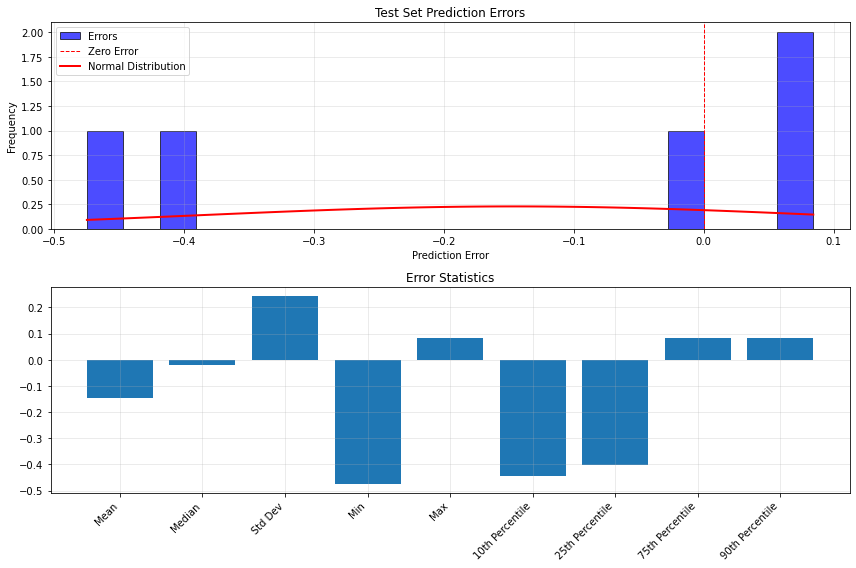


Error Statistics:
Mean: -0.1461
Median: -0.0209
Std Dev: 0.2431
Min: -0.4745
Max: 0.0844
10th Percentile: -0.4459
25th Percentile: -0.4031
75th Percentile: 0.0834
90th Percentile: 0.0840

Mean Absolute Error: 0.2133
Within 0.05 error: 20.00%
Within 0.15 error: 60.00%
Within 0.25 error: 60.00%


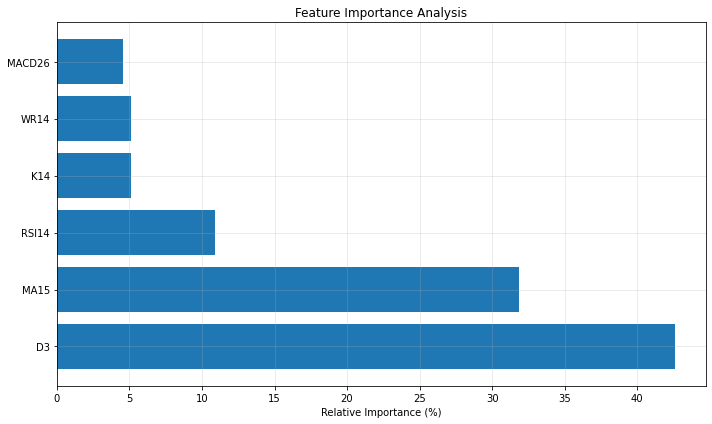

Cross-validation RMSE: 0.3236 ± 0.0381


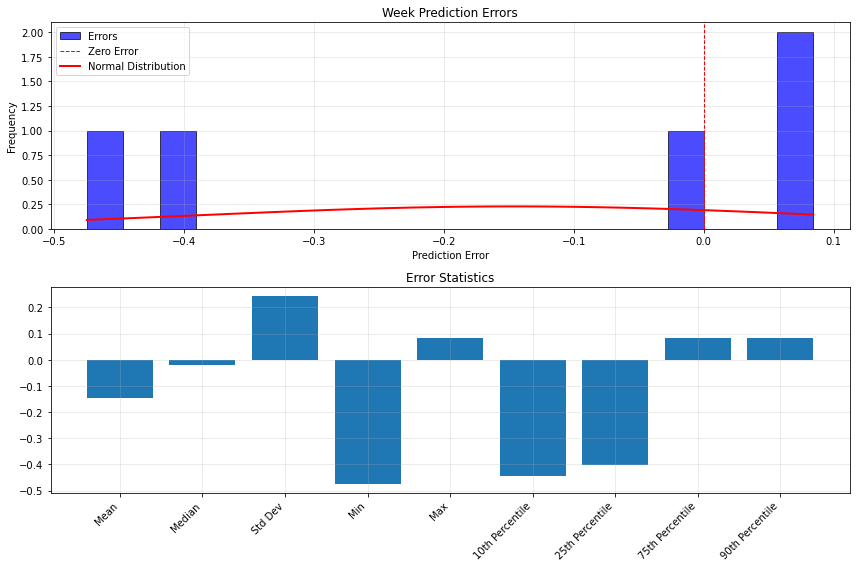


Error Statistics:
Mean: -0.1461
Median: -0.0209
Std Dev: 0.2431
Min: -0.4745
Max: 0.0844
10th Percentile: -0.4459
25th Percentile: -0.4031
75th Percentile: 0.0834
90th Percentile: 0.0840

Mean Absolute Error: 0.2133
Within 0.05 error: 20.00%
Within 0.15 error: 60.00%
Within 0.25 error: 60.00%


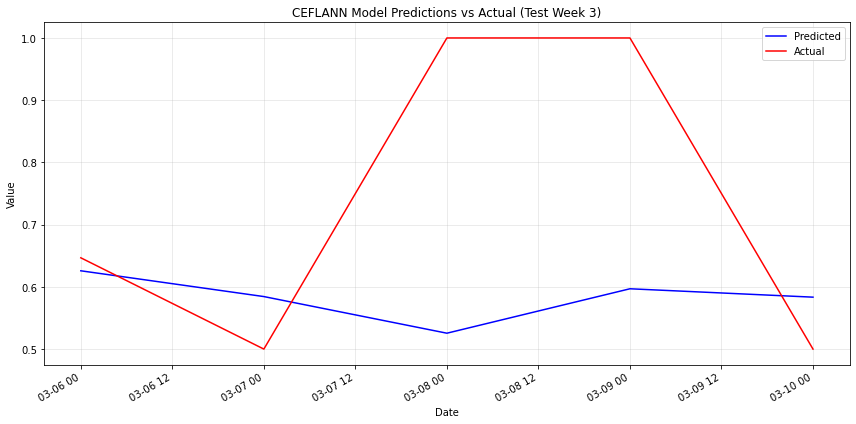

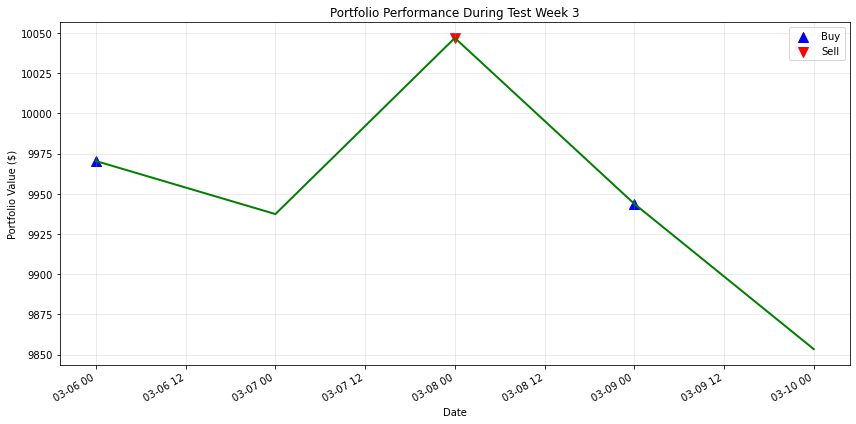


===== TEST WEEK 3 RESULTS =====
Date range: 2023-03-06T00:00:00.000000000 to 2023-03-10T00:00:00.000000000
Number of days: 5

===== MODEL PERFORMANCE =====
MSE: 0.0804
RMSE: 0.2836
R²: -0.5554
MAE: 0.2133
Training Time: 0.0015 seconds

===== DAILY ORDERS =====
Day 1: Buy: 126 shares @ $23.53 ($2965.37)
Day 2: Hold
Day 3: Sell: 12 shares @ $24.17 ($289.98)
Day 4: Buy: 78 shares @ $23.42 ($1826.82)
Day 5: Hold
===== TRADING SUMMARY =====
Initial Portfolio: $10000.00
Final Portfolio: $9853.38
Profits/Losses: $-146.62 (-1.47%)
Total Transaction Fees: $50.82
Number of Buys: 2
Number of Sells: 1


In [104]:
# Step 1: Evaluation on a single week
print("\nEvaluation on a recent test week")
quick_results = ceflann_workflow(nvidia_data, operation='quick_eval', week_index=2)



STEP 2: Training and saving optimal model

=== TRAINING AND SAVING OPTIMAL MODEL ===
Optimizing hyperparameters...
Testing expansion_order=3, regularization=0.001
New best: expansion_order=3, regularization=0.001, MSE=0.125012
Testing expansion_order=3, regularization=0.01
New best: expansion_order=3, regularization=0.01, MSE=0.100433
Testing expansion_order=3, regularization=0.1
New best: expansion_order=3, regularization=0.1, MSE=0.088158
Testing expansion_order=3, regularization=1.0
New best: expansion_order=3, regularization=1.0, MSE=0.082292
Testing expansion_order=3, regularization=10.0
Testing expansion_order=5, regularization=0.001
Testing expansion_order=5, regularization=0.01
Testing expansion_order=5, regularization=0.1
Testing expansion_order=5, regularization=1.0
Testing expansion_order=5, regularization=10.0
New best: expansion_order=5, regularization=10.0, MSE=0.082204
Testing expansion_order=7, regularization=0.001
Testing expansion_order=7, regularization=0.01
Testing

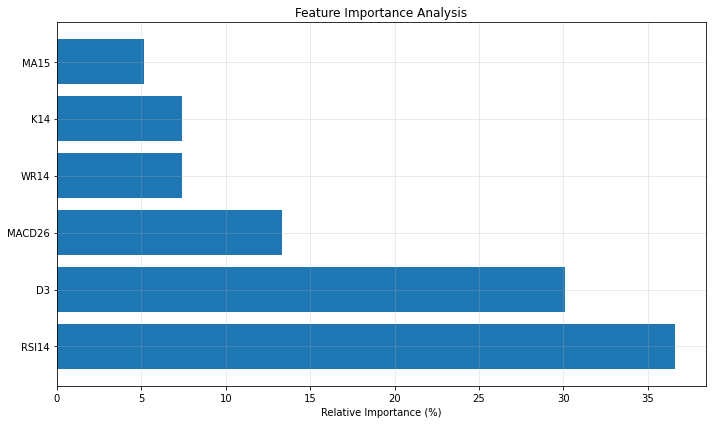

Model saved to models/ceflann_optimal.npy with metadata at models/ceflann_optimal_metadata.json


In [105]:
# Step 2: Train and save optimal model
print("\nSTEP 2: Training and saving optimal model")
optimal_model_results = ceflann_workflow(nvidia_data, operation='optimize')
optimal_model = optimal_model_results['model']


STEP 3: Running comprehensive evaluation

=== COMPREHENSIVE EVALUATION ===
Loading pre-trained model...
Loaded model from models/ceflann_optimal.npy with metadata
Model parameters: expansion_order=7, regularization=10.0
Model performance: RMSE=0.2872, R²=0.0000
Trained on: 2025-03-23 20:04:24

Evaluating on test dataset...


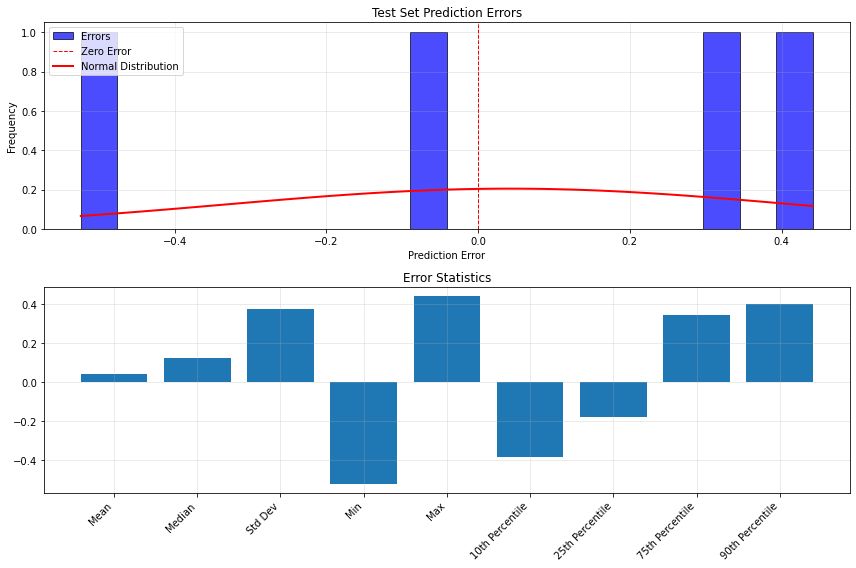


Error Statistics:
Mean: 0.0423
Median: 0.1256
Std Dev: 0.3757
Min: -0.5236
Max: 0.4414
10th Percentile: -0.3854
25th Percentile: -0.1782
75th Percentile: 0.3460
90th Percentile: 0.4033

Mean Absolute Error: 0.3356
Within 0.05 error: 0.00%
Within 0.15 error: 25.00%
Within 0.25 error: 25.00%


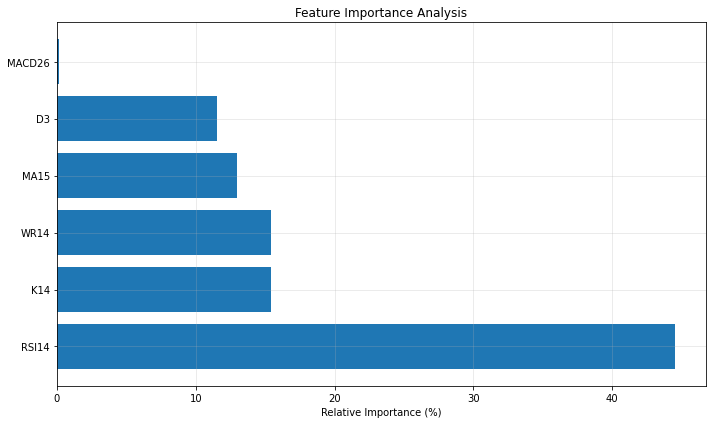

Cross-validation RMSE: 0.3233 ± 0.0321


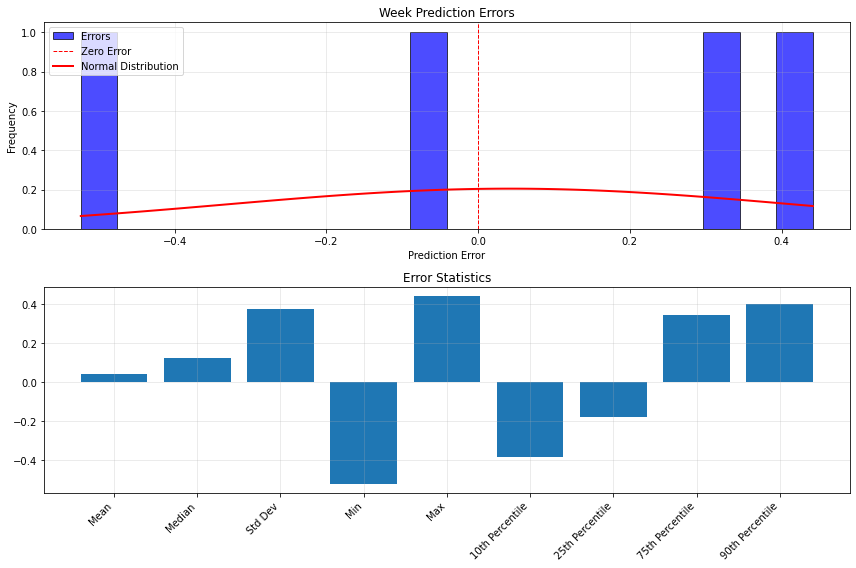


Error Statistics:
Mean: 0.0423
Median: 0.1256
Std Dev: 0.3757
Min: -0.5236
Max: 0.4414
10th Percentile: -0.3854
25th Percentile: -0.1782
75th Percentile: 0.3460
90th Percentile: 0.4033

Mean Absolute Error: 0.3356
Within 0.05 error: 0.00%
Within 0.15 error: 25.00%
Within 0.25 error: 25.00%

===== TEST WEEK 1 RESULTS =====
Date range: 2023-02-21T00:00:00.000000000 to 2023-02-24T00:00:00.000000000
Number of days: 4

===== MODEL PERFORMANCE =====
MSE: 0.1429
RMSE: 0.3781
R²: 0.2162
MAE: 0.3356
Training Time: 0.0010 seconds

===== DAILY ORDERS =====
Day 1: Buy: 47 shares @ $20.64 ($969.99)
Day 2: Sell: 18 shares @ $20.74 ($373.27)
Day 3: Hold
Day 4: Buy: 78 shares @ $23.27 ($1814.82)
===== TRADING SUMMARY =====
Initial Portfolio: $10000.00
Final Portfolio: $10046.44
Profits/Losses: $46.44 (0.46%)
Total Transaction Fees: $31.58
Number of Buys: 2
Number of Sells: 1


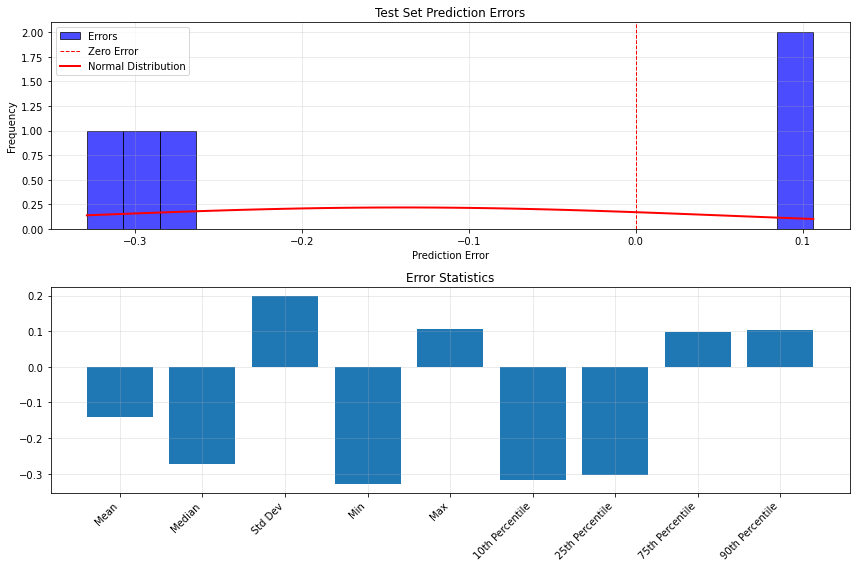


Error Statistics:
Mean: -0.1396
Median: -0.2722
Std Dev: 0.1985
Min: -0.3287
Max: 0.1064
10th Percentile: -0.3181
25th Percentile: -0.3022
75th Percentile: 0.0986
90th Percentile: 0.1033

Mean Absolute Error: 0.2216
Within 0.05 error: 0.00%
Within 0.15 error: 40.00%
Within 0.25 error: 40.00%


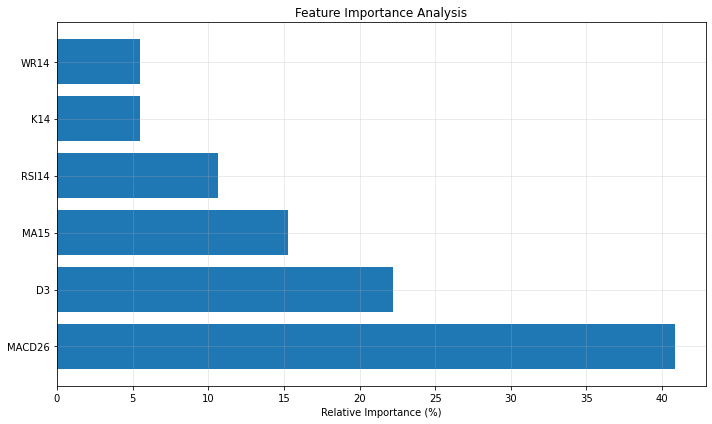

Cross-validation RMSE: 0.3027 ± 0.0240


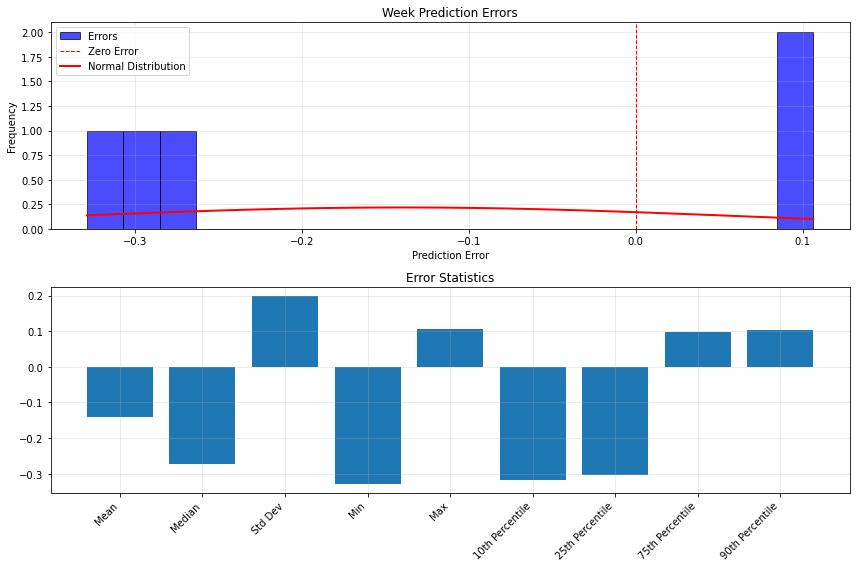


Error Statistics:
Mean: -0.1396
Median: -0.2722
Std Dev: 0.1985
Min: -0.3287
Max: 0.1064
10th Percentile: -0.3181
25th Percentile: -0.3022
75th Percentile: 0.0986
90th Percentile: 0.1033

Mean Absolute Error: 0.2216
Within 0.05 error: 0.00%
Within 0.15 error: 40.00%
Within 0.25 error: 40.00%

===== TEST WEEK 2 RESULTS =====
Date range: 2023-02-27T00:00:00.000000000 to 2023-03-03T00:00:00.000000000
Number of days: 5

===== MODEL PERFORMANCE =====
MSE: 0.0589
RMSE: 0.2427
R²: -0.0777
MAE: 0.2216
Training Time: 0.0020 seconds

===== DAILY ORDERS =====
Day 1: Buy: 175 shares @ $23.48 ($4109.31)
Day 2: Hold
Day 3: Sell: 17 shares @ $22.68 ($385.55)
Day 4: Hold
Day 5: Buy: 96 shares @ $23.87 ($2291.56)
===== TRADING SUMMARY =====
Initial Portfolio: $10000.00
Final Portfolio: $9979.91
Profits/Losses: $-20.09 (-0.20%)
Total Transaction Fees: $67.86
Number of Buys: 2
Number of Sells: 1


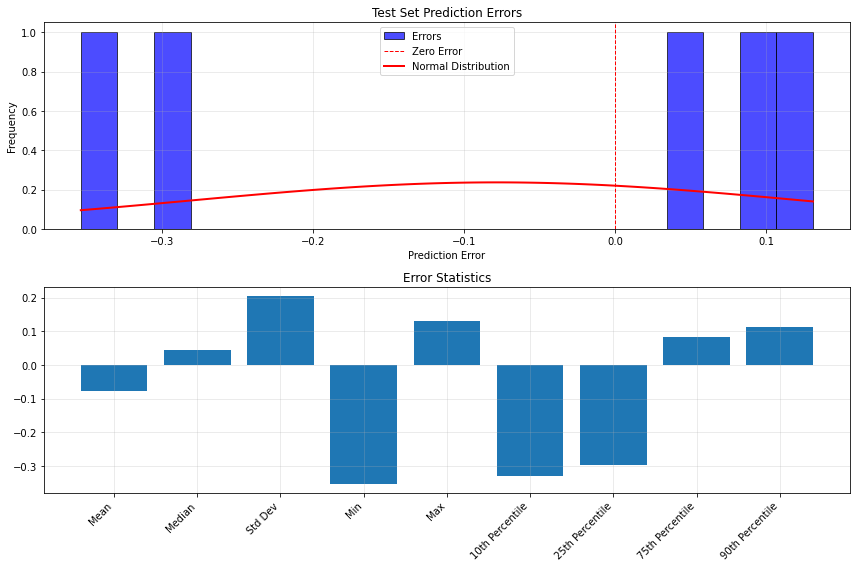


Error Statistics:
Mean: -0.0785
Median: 0.0430
Std Dev: 0.2041
Min: -0.3538
Max: 0.1309
10th Percentile: -0.3308
25th Percentile: -0.2964
75th Percentile: 0.0839
90th Percentile: 0.1121

Mean Absolute Error: 0.1816
Within 0.05 error: 20.00%
Within 0.15 error: 60.00%
Within 0.25 error: 60.00%


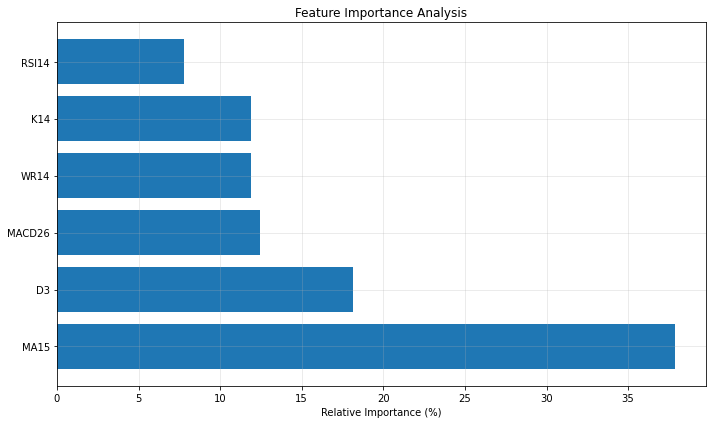

Cross-validation RMSE: 0.3227 ± 0.0260


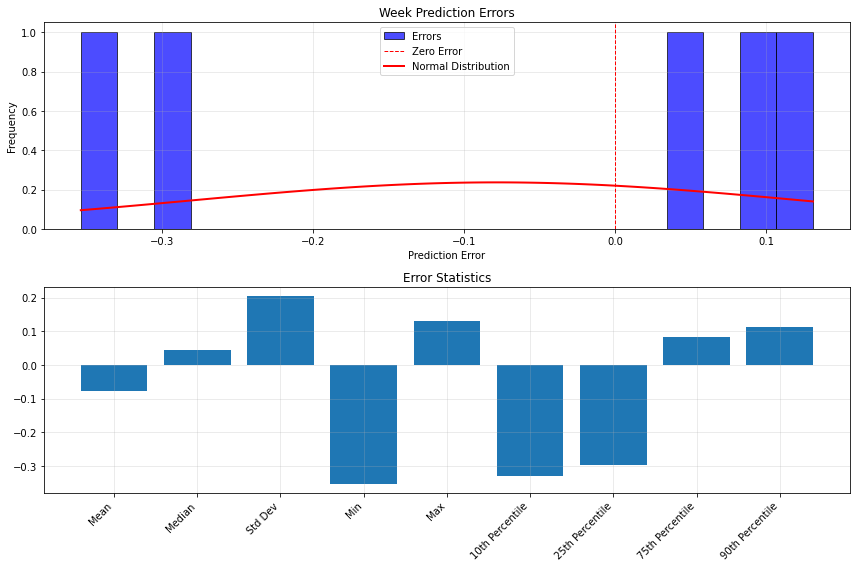


Error Statistics:
Mean: -0.0785
Median: 0.0430
Std Dev: 0.2041
Min: -0.3538
Max: 0.1309
10th Percentile: -0.3308
25th Percentile: -0.2964
75th Percentile: 0.0839
90th Percentile: 0.1121

Mean Absolute Error: 0.1816
Within 0.05 error: 20.00%
Within 0.15 error: 60.00%
Within 0.25 error: 60.00%

===== TEST WEEK 3 RESULTS =====
Date range: 2023-03-06T00:00:00.000000000 to 2023-03-10T00:00:00.000000000
Number of days: 5

===== MODEL PERFORMANCE =====
MSE: 0.0478
RMSE: 0.2187
R²: 0.0754
MAE: 0.1816
Training Time: 0.0000 seconds

===== DAILY ORDERS =====
Day 1: Buy: 169 shares @ $23.53 ($3977.37)
Day 2: Hold
Day 3: Buy: 104 shares @ $24.17 ($2513.19)
Day 4: Hold
Day 5: Sell: 27 shares @ $22.95 ($619.65)
===== TRADING SUMMARY =====
Initial Portfolio: $10000.00
Final Portfolio: $9703.72
Profits/Losses: $-296.28 (-2.96%)
Total Transaction Fees: $71.10
Number of Buys: 2
Number of Sells: 1

Evaluating on evaluation dataset...


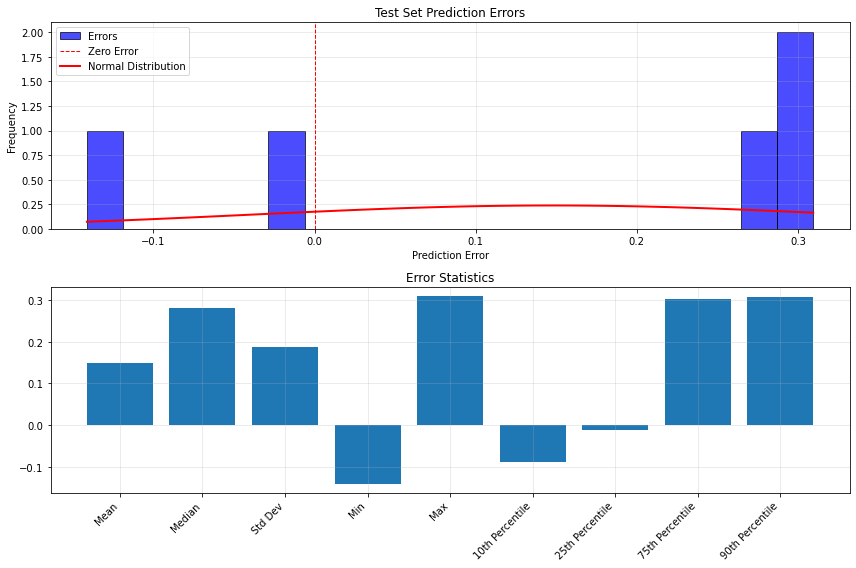


Error Statistics:
Mean: 0.1479
Median: 0.2800
Std Dev: 0.1881
Min: -0.1413
Max: 0.3095
10th Percentile: -0.0897
25th Percentile: -0.0122
75th Percentile: 0.3033
90th Percentile: 0.3070

Mean Absolute Error: 0.2093
Within 0.05 error: 20.00%
Within 0.15 error: 40.00%
Within 0.25 error: 40.00%


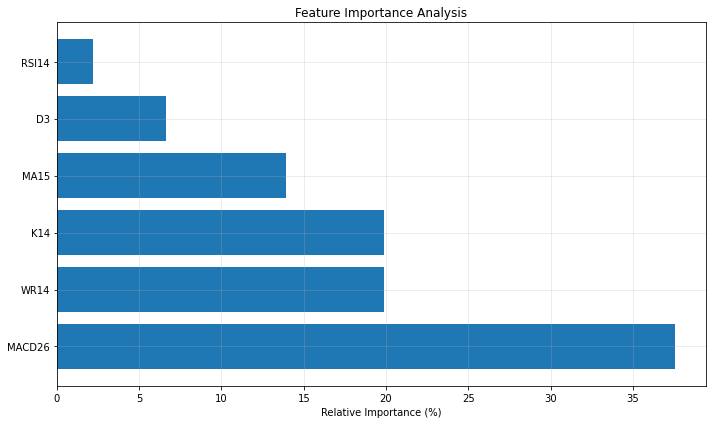

Cross-validation RMSE: 0.3143 ± 0.0237


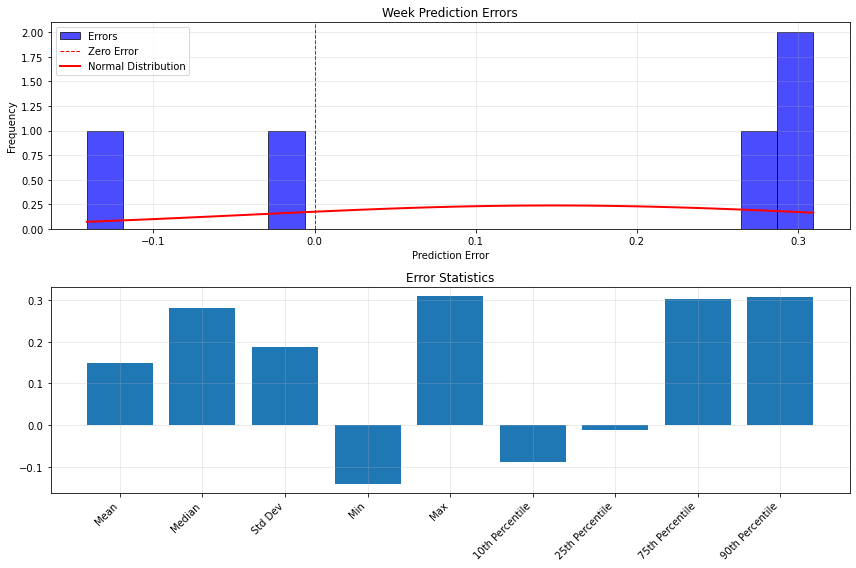


Error Statistics:
Mean: 0.1479
Median: 0.2800
Std Dev: 0.1881
Min: -0.1413
Max: 0.3095
10th Percentile: -0.0897
25th Percentile: -0.0122
75th Percentile: 0.3033
90th Percentile: 0.3070

Mean Absolute Error: 0.2093
Within 0.05 error: 20.00%
Within 0.15 error: 40.00%
Within 0.25 error: 40.00%

===== EVAL WEEK 1 RESULTS =====
Date range: 2024-02-26T00:00:00.000000000 to 2024-03-01T00:00:00.000000000
Number of days: 5

===== MODEL PERFORMANCE =====
MSE: 0.0573
RMSE: 0.2393
R²: -0.2395
MAE: 0.2093
Training Time: 0.0010 seconds

===== DAILY ORDERS =====
Day 1: Buy: 84 shares @ $79.06 ($6641.24)
Day 2: Buy: 27 shares @ $78.67 ($2124.13)
Day 3: Sell: 11 shares @ $77.63 ($853.97)
Day 4: Hold
Day 5: Hold
===== TRADING SUMMARY =====
Initial Portfolio: $10000.00
Final Portfolio: $10217.23
Profits/Losses: $217.23 (2.17%)
Total Transaction Fees: $96.19
Number of Buys: 2
Number of Sells: 1


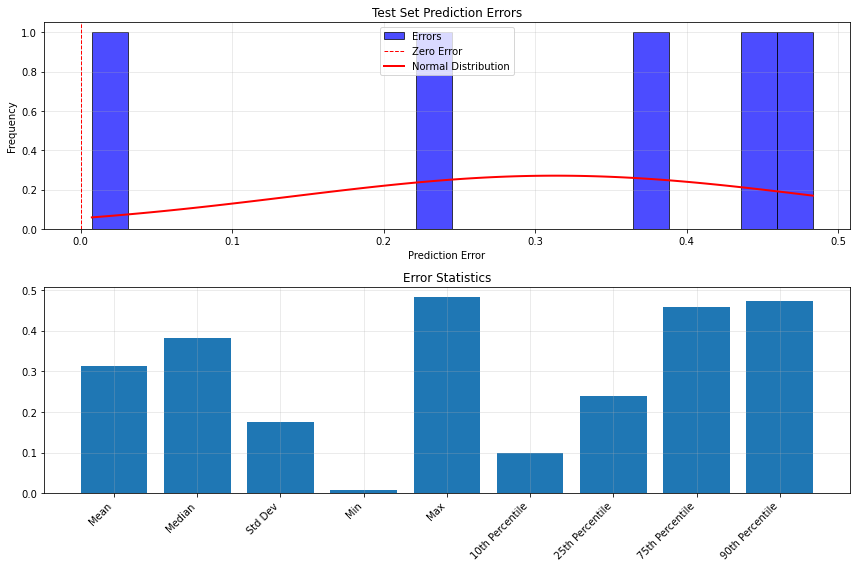


Error Statistics:
Mean: 0.3134
Median: 0.3805
Std Dev: 0.1752
Min: 0.0073
Max: 0.4833
10th Percentile: 0.0997
25th Percentile: 0.2382
75th Percentile: 0.4577
90th Percentile: 0.4731

Mean Absolute Error: 0.3134
Within 0.05 error: 20.00%
Within 0.15 error: 20.00%
Within 0.25 error: 40.00%


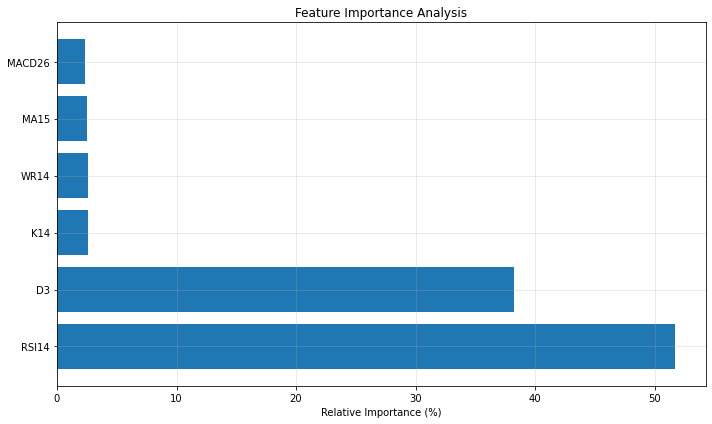

Cross-validation RMSE: 0.3140 ± 0.0257


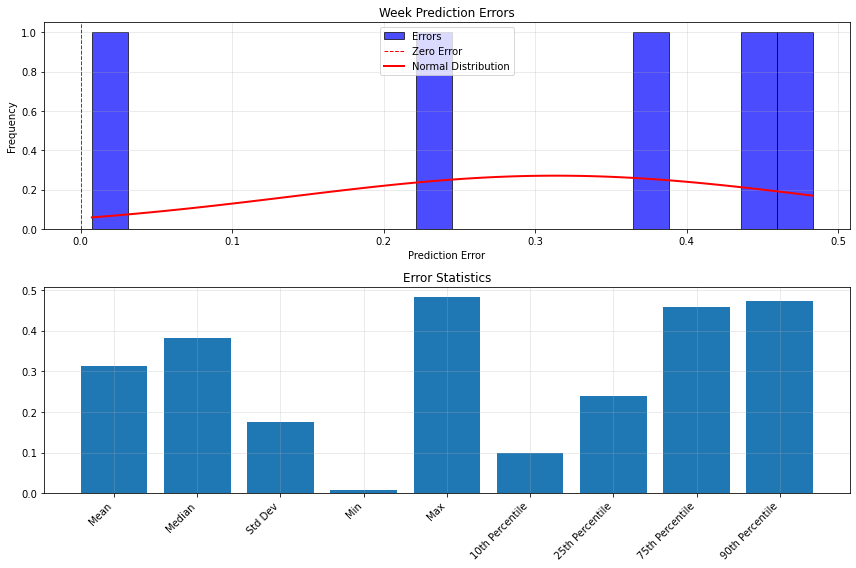


Error Statistics:
Mean: 0.3134
Median: 0.3805
Std Dev: 0.1752
Min: 0.0073
Max: 0.4833
10th Percentile: 0.0997
25th Percentile: 0.2382
75th Percentile: 0.4577
90th Percentile: 0.4731

Mean Absolute Error: 0.3134
Within 0.05 error: 20.00%
Within 0.15 error: 20.00%
Within 0.25 error: 40.00%

===== EVAL WEEK 2 RESULTS =====
Date range: 2024-03-04T00:00:00.000000000 to 2024-03-08T00:00:00.000000000
Number of days: 5

===== MODEL PERFORMANCE =====
MSE: 0.1289
RMSE: 0.3591
R²: -2.8180
MAE: 0.3134
Training Time: 0.0000 seconds

===== DAILY ORDERS =====
Day 1: Buy: 96 shares @ $85.20 ($8179.68)
Day 2: Hold
Day 3: Hold
Day 4: Buy: 16 shares @ $92.64 ($1482.22)
Day 5: Sell: 11 shares @ $87.50 ($962.49)
===== TRADING SUMMARY =====
Initial Portfolio: $10000.00
Final Portfolio: $10031.78
Profits/Losses: $31.78 (0.32%)
Total Transaction Fees: $106.24
Number of Buys: 2
Number of Sells: 1


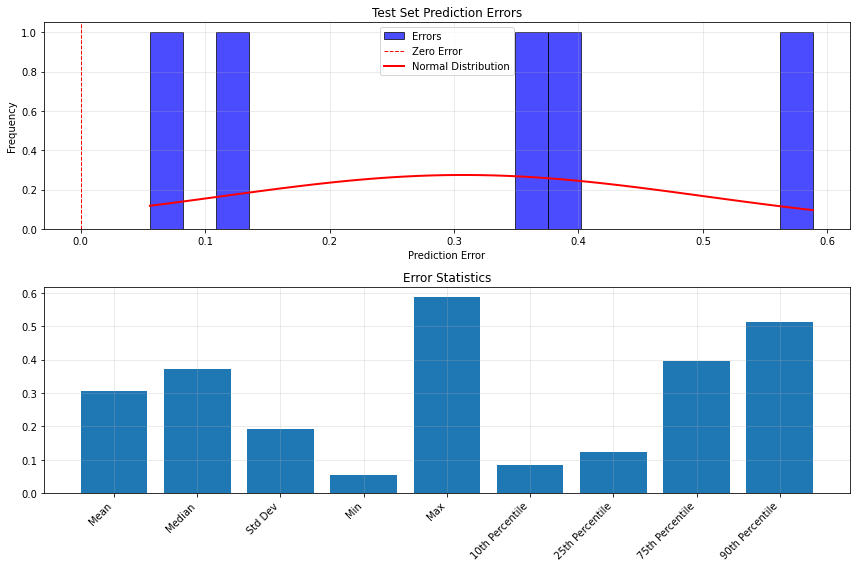


Error Statistics:
Mean: 0.3073
Median: 0.3724
Std Dev: 0.1937
Min: 0.0555
Max: 0.5885
10th Percentile: 0.0833
25th Percentile: 0.1251
75th Percentile: 0.3949
90th Percentile: 0.5111

Mean Absolute Error: 0.3073
Within 0.05 error: 0.00%
Within 0.15 error: 40.00%
Within 0.25 error: 40.00%


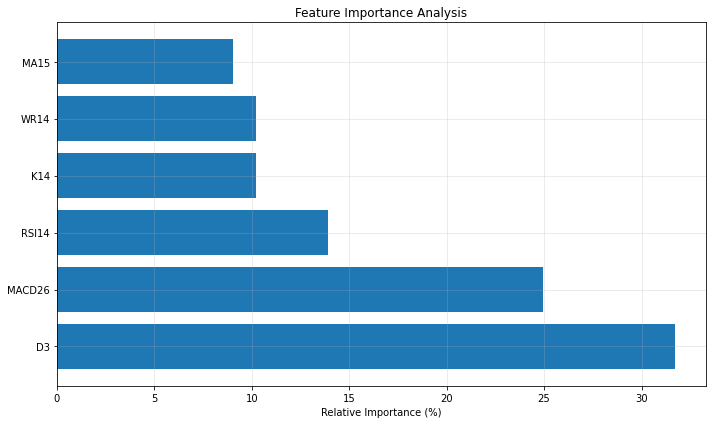

Cross-validation RMSE: 0.3093 ± 0.0233


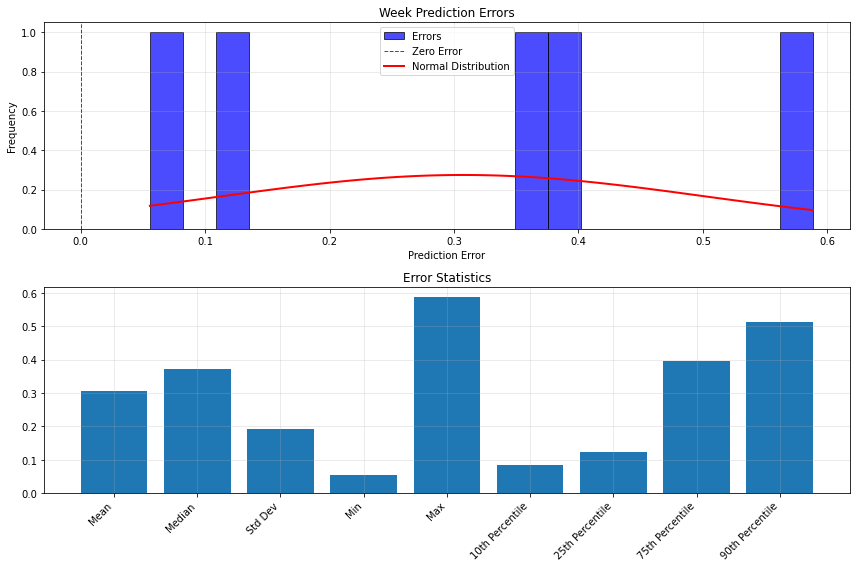


Error Statistics:
Mean: 0.3073
Median: 0.3724
Std Dev: 0.1937
Min: 0.0555
Max: 0.5885
10th Percentile: 0.0833
25th Percentile: 0.1251
75th Percentile: 0.3949
90th Percentile: 0.5111

Mean Absolute Error: 0.3073
Within 0.05 error: 0.00%
Within 0.15 error: 40.00%
Within 0.25 error: 40.00%

===== EVAL WEEK 3 RESULTS =====
Date range: 2024-03-11T00:00:00.000000000 to 2024-03-15T00:00:00.000000000
Number of days: 5

===== MODEL PERFORMANCE =====
MSE: 0.1319
RMSE: 0.3632
R²: -1.4311
MAE: 0.3073
Training Time: 0.0009 seconds

===== DAILY ORDERS =====
Day 1: Buy: 103 shares @ $85.75 ($8831.82)
Day 2: Buy: 10 shares @ $91.88 ($918.83)
Day 3: Hold
Day 4: Hold
Day 5: Sell: 11 shares @ $87.81 ($965.89)
===== TRADING SUMMARY =====
Initial Portfolio: $10000.00
Final Portfolio: $10064.51
Profits/Losses: $64.51 (0.65%)
Total Transaction Fees: $107.17
Number of Buys: 2
Number of Sells: 1

=== SUMMARY STATISTICS ===
Test dataset average profit: -0.90%
Test dataset profit range: -2.96% to 0.46%
Evaluati

In [106]:
# Step 3: Comprehensive evaluation on test and evaluation datasets
print("\nSTEP 3: Running comprehensive evaluation")
comprehensive_results = ceflann_workflow(nvidia_data, operation='comprehensive')

In [107]:
# Step 4: Future price prediction (March 24-28, 2025)
print("\nSTEP 4: Price Predictions (March 24-28, 2025)")
prediction_results = ceflann_workflow(nvidia_data, operation='predict')


STEP 4: Price Predictions (March 24-28, 2025)

=== FUTURE WEEK PREDICTION (March 24-28, 2025) ===
Loading optimized model:
Loaded model from models/ceflann_optimal.npy with metadata
Model parameters: expansion_order=7, regularization=10.0
Model performance: RMSE=0.2872, R²=0.0000
Trained on: 2025-03-23 20:04:24

Gathering prediction data:
Historical daily volatility: 0.0582 (5.82%)

Generating trading signals and price estimates...
Starting from latest price: $121.67

=== FORECAST FOR MARCH 24-28, 2025 ===
Date            Signal   Action Median Price    80% CI               95% CI              
------------------------------------------------------------------------------------------
March 24, 2025  0.1347 BUY    $118.02   $118.02-$118.02   $118.02-$118.02
March 25, 2025  0.1559 SELL   $114.48   $114.48-$114.48   $114.48-$115.12
March 26, 2025  0.2278 SELL   $111.04   $111.04-$111.82   $111.04-$113.41
March 27, 2025  0.2730 HOLD   $107.71   $107.71-$109.76   $107.71-$112.16
March 28, 

In [108]:
# Summary of all results
print("\n===== SUMMARY =====")
print(f"Quick evaluation profit: ${quick_results['simulation_results']['profit']:.2f}")

if 'test_results' in comprehensive_results and comprehensive_results['test_results']:
    test_profits = [r['profit_percent'] for r in comprehensive_results['test_results']]
    print(f"Test dataset average profit: {np.mean(test_profits):.2f}%")

if 'eval_results' in comprehensive_results and comprehensive_results['eval_results']:
    eval_profits = [r['profit_percent'] for r in comprehensive_results['eval_results']]
    print(f"Evaluation dataset average profit: {np.mean(eval_profits):.2f}%")




===== SUMMARY =====
Quick evaluation profit: $-146.62
Test dataset average profit: -0.90%
Evaluation dataset average profit: 1.05%
